<a href="https://colab.research.google.com/github/abjodas/GP-ENSO/blob/main/GPENSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
from bokeh.io import output_notebook
from bokeh.models import BoxAnnotation, Label, Legend, Span
from bokeh.palettes import brewer
from bokeh.plotting import figure, show
from scipy.signal import savgol_filter

output_notebook()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

In [ ]:
df = pd.read_csv('nino34.long.anom.csv')
df.columns = ['Date', 'NINA34']
df.head()

Date  NINA34
0  1870-01-01   -1.00
1  1870-02-01   -1.20
2  1870-03-01   -0.83
3  1870-04-01   -0.81
4  1870-05-01   -1.27

In [ ]:
df['NINA34'] = df['NINA34'].replace(-9999, np.nan)
df['NINA34'].isna().sum()

np.int64(4)

In [ ]:
df = df.dropna()
df['NINA34'].isna().sum()

np.int64(0)

In [ ]:
df['NINA34_smoothed'] = df['NINA34'].rolling(window=3, center=True).mean()
# df['NINA12_smoothed'] = savgol_filter(
#     df['NINA12'],
#     window_length=11,
#     polyorder=3
# )
# df['NINA12_smoothed'] = df['NINA12'].ewm(span=12).mean()
df = df.dropna(subset=['NINA34_smoothed'])

In [ ]:
df.index = pd.to_datetime(df.Date)
df.head()

Date  NINA34  NINA34_smoothed
Date                                           
1870-02-01  1870-02-01   -1.20        -1.010000
1870-03-01  1870-03-01   -0.83        -0.946667
1870-04-01  1870-04-01   -0.81        -0.970000
1870-05-01  1870-05-01   -1.27        -1.053333
1870-06-01  1870-06-01   -1.08        -1.130000

In [ ]:
df.tail()

Date  NINA34  NINA34_smoothed
Date                                           
2025-03-01  2025-03-01    0.05        -0.140000
2025-04-01  2025-04-01   -0.08        -0.036667
2025-05-01  2025-05-01   -0.08        -0.050000
2025-06-01  2025-06-01    0.01        -0.033333
2025-07-01  2025-07-01   -0.03        -0.043333

In [ ]:
def dates_to_idx(timelist):
    reference_time = pd.to_datetime("1870-08-01")
    t = (timelist - reference_time) / pd.Timedelta(365, "D")
    return np.asarray(t)

t = dates_to_idx(df.index)

# Normalise the output values
y = df['NINA34'].values
first_nina= y[0]
std_nina = np.std(y)
y_n = (y - first_nina) / std_nina

df = df.assign(t=t)
data_monthly = df.assign(y_n=y_n)

In [ ]:
p = figure(
    x_axis_type='datetime',
    title='NINO 3.4 Index over time',
    width=800,
    height=500
)
p.yaxis.axis_label = 'NINO3.4'
p.xaxis.axis_label = 'Date'

zeroline = Span(location=0, dimension='width', line_color='red', line_dash='dashed', line_width=2)
p.add_layout(zeroline)

p.line(df.index, df['NINA34_smoothed'], line_width=2, line_color='black', alpha=0.5)

show(p)

Text(0.5, 1.0, 'Autocorrelation Function')

<Figure size 1200x500 with 0 Axes>

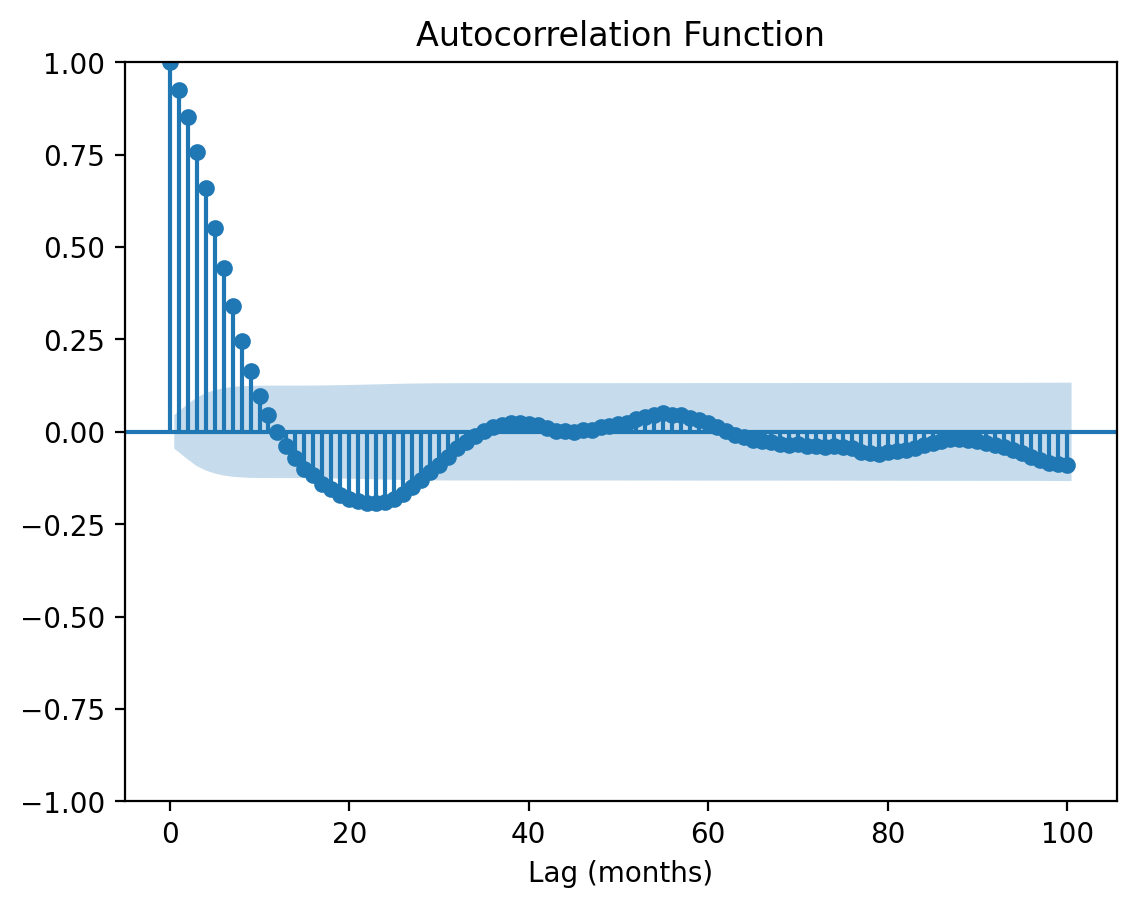

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plot_acf(df['NINA34'].dropna(), lags=100)
plt.xlabel('Lag (months)')
plt.title('Autocorrelation Function')

Dominant period: 2.88 years


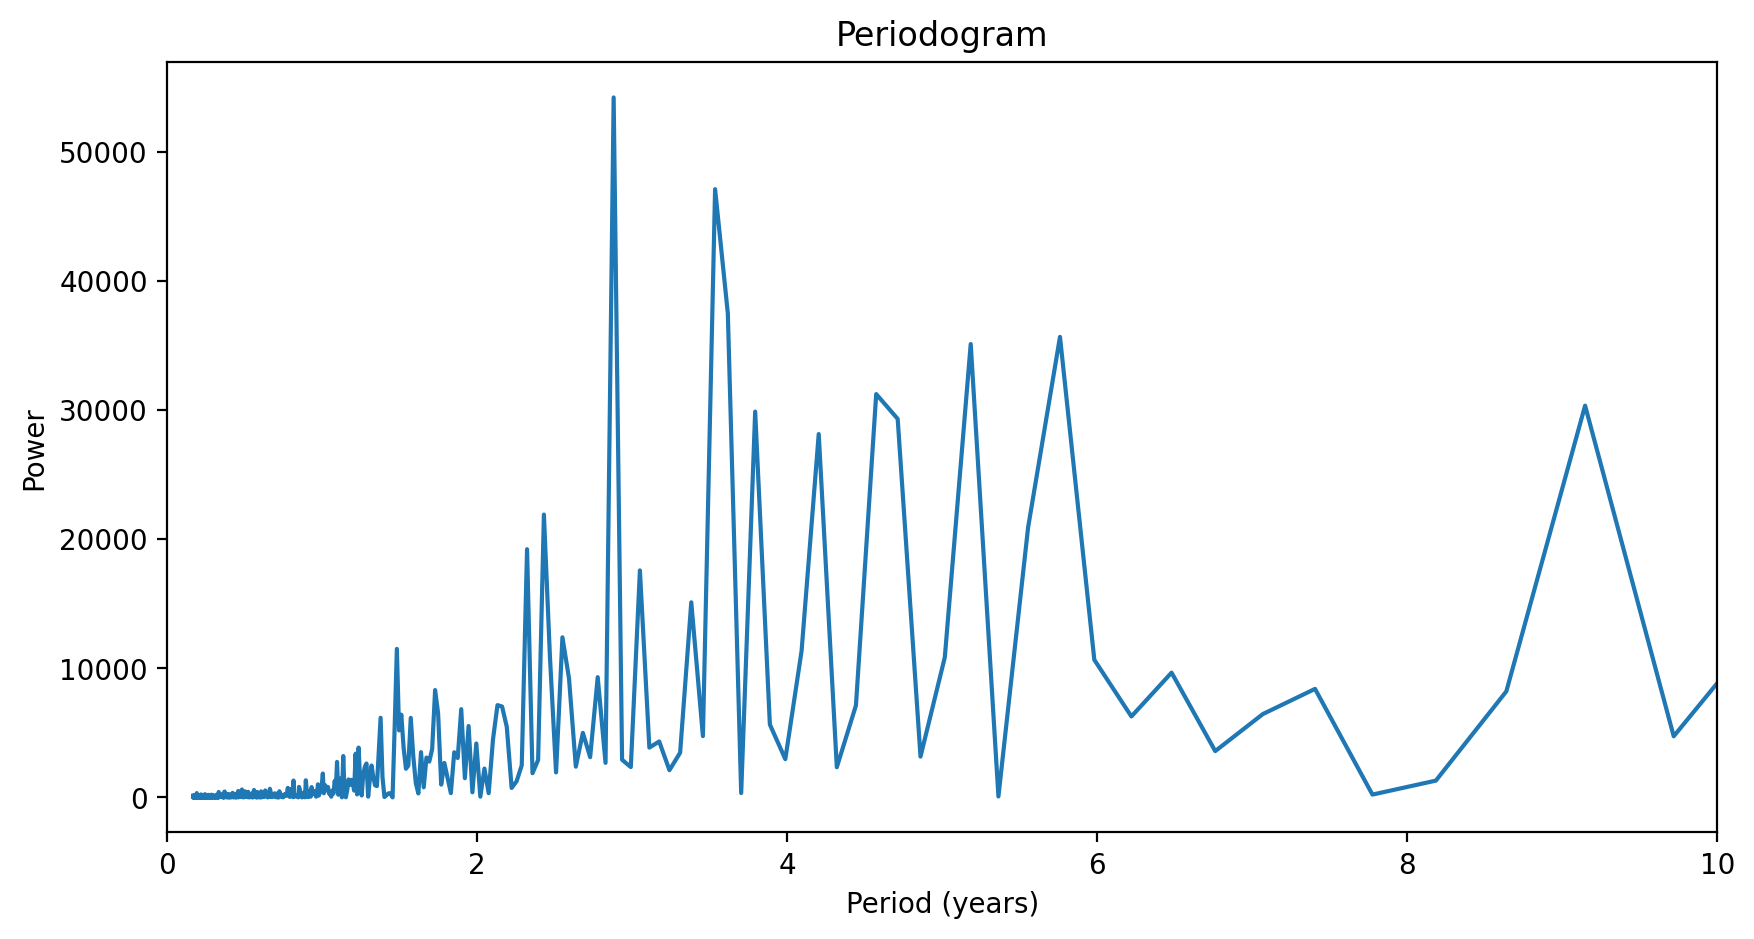

In [ ]:
from scipy.fft import fft, fftfreq

data = df['NINA34'].dropna().values
n = len(data)

# Compute FFT
fft_vals = fft(data)
fft_power = np.abs(fft_vals)**2

# Get frequencies
freqs = fftfreq(n, d=1/12)  # d = 1/12 for monthly data

# Only positive frequencies
pos_mask = freqs > 0
freqs = freqs[pos_mask]
fft_power = fft_power[pos_mask]

# Convert to periods
periods = 1 / freqs

# Plot
plt.figure(figsize=(10, 5))
plt.plot(periods, fft_power)
plt.xlabel('Period (years)')
plt.ylabel('Power')
plt.xlim(0, 10)
plt.title('Periodogram')

# Find peak
peak_idx = np.argmax(fft_power)
print(f"Dominant period: {periods[peak_idx]:.2f} years")

In [ ]:
def dates_to_idx(timelist):
    reference_time = pd.to_datetime("1870-08-01")
    t = (timelist - reference_time) / pd.Timedelta(365, "D")
    return np.asarray(t)
t = dates_to_idx(df.index)

y = df['NINA34_smoothed'].values
first_nina = y[0]
y_std = np.std(y)
y_n = (y - first_nina) / y_std

df = df.assign(t=t)
df = df.assign(y_n=y_n)

In [ ]:
t = df['t'].values[:, None]
y = df['y_n'].values

In [ ]:
with pm.Model() as model:
    # Quasi periodic
    n_per1 = pm.HalfCauchy('n_per1', beta=1.5, initval=0.5)
    l_per1 = pm.Gamma('l_per1', alpha=1, beta=2)
    period_1 = pm.Gamma('period_1', alpha=8, beta=2)
    l_exp = pm.Gamma('l_exp', alpha=2, beta=1)
    cov_per1 = n_per1**2 * pm.gp.cov.ExpQuad(1, l_exp) * pm.gp.cov.Periodic(1, period_1, l_per1)

    # noise model
    σ = pm.HalfNormal("σ", sigma=0.25, initval=0.1)
    n_noise = pm.HalfNormal('n_noise', sigma=0.5, initval=0.05)
    l_noise = pm.Gamma('l_noise', alpha=2, beta=4)
    cov_noise = n_noise**2 * pm.gp.cov.Matern32(1, l_noise)
    # The Gaussian process is a sum of these three components
    cov_total = cov_per1 + cov_noise

    gp = pm.gp.Marginal(cov_func=cov_total)

    # Since the normal noise model and the GP are conjugates, we use `Marginal` with the `.marginal_likelihood` method
    y_ = gp.marginal_likelihood("y", X=t, y=y, sigma=σ)

    # this line calls an optimizer to find the MAP
    mp = pm.find_MAP(include_transformed=True)

Output()

In [ ]:
# display the results, dont show transformed parameter values
sorted([name + ":" + str(mp[name]) for name in mp.keys() if not name.endswith("_")])

In [ ]:
dates = pd.date_range(start="1870-01-01", end="08/01/2040", freq="30D")
tnew = dates_to_idx(dates)[:, None]

print("Sampling gp predictions ...")
with model:
    mu_pred, cov_pred = gp.predict(tnew, point=mp)

# draw samples, and rescale
n_samples = 5
samples = pm.draw(pm.MvNormal.dist(mu=mu_pred, cov=cov_pred), draws=n_samples)
samples = samples * y_std + first_nina

In [ ]:
# make plot
p = figure(x_axis_type="datetime", width=700, height=300)
p.yaxis.axis_label = "Nino 1.2"
p.xaxis.axis_label = "Date"

# plot mean and 2σ region of total prediction
# scale mean and var
mu_pred_sc = mu_pred * y_std + first_nina
sd_pred_sc = np.sqrt(np.diag(cov_pred) * y_std**2)

upper = mu_pred_sc + 2 * sd_pred_sc
lower = mu_pred_sc - 2 * sd_pred_sc
band_x = np.append(dates, dates[::-1])
band_y = np.append(lower, upper[::-1])

p.line(dates, mu_pred_sc, line_width=2, line_color="firebrick", legend_label="Total fit")
p.patch(band_x, band_y, color="firebrick", alpha=0.6, line_color="white")

# some predictions
idx = np.random.randint(0, samples.shape[0], 10)
p.multi_line(
    [dates] * len(idx),
    [samples[i, :] for i in idx],
    color="firebrick",
    alpha=0.5,
    line_width=0.5,
)

# true value
# p.circle(data_later.index, data_later["CO2"], color="black", legend_label="Observed data")
predline = Span(location=pd.to_datetime('2025-08-01'), dimension='height', line_color='red', line_dash='dashed', line_width=2)
p.add_layout(predline)
p.scatter(
    df.index,
    df["Date"],
    marker="circle",
    line_color="black",
    alpha=0.1,
    size=5,
    legend_label="Observed data",
)

p.legend.location = "bottom_right"
show(p)

In [ ]:
import seaborn
seaborn.load_dataset('flights')

year month  passengers
0    1949   Jan         112
1    1949   Feb         118
2    1949   Mar         132
3    1949   Apr         129
4    1949   May         121
..    ...   ...         ...
139  1960   Aug         606
140  1960   Sep         508
141  1960   Oct         461
142  1960   Nov         390
143  1960   Dec         432

[144 rows x 3 columns]

In [ ]:
url = "https://www.sidc.be/SILSO/INFO/snmtotcsv.php"
df = pd.read_csv(url, sep=';', header=None,
                 names=['Year', 'Month', 'Date', 'Sunspot_Number', 'StdDev', 'Observations', 'Definitive'])
df.head()

Year  Month      Date  Sunspot_Number  StdDev  Observations  Definitive
0  1749      1  1749.042            96.7    -1.0            -1           1
1  1749      2  1749.123           104.3    -1.0            -1           1
2  1749      3  1749.204           116.7    -1.0            -1           1
3  1749      4  1749.288            92.8    -1.0            -1           1
4  1749      5  1749.371           141.7    -1.0            -1           1

In [ ]:
df['Date'] = pd.to_datetime(df['Year'], format='%Y')
df.tail()

Year  Month       Date  Sunspot_Number  StdDev  Observations  Definitive
3319  2025      8 2025-01-01           133.5    18.2          1114           0
3320  2025      9 2025-01-01           129.8    15.4           961           0
3321  2025     10 2025-01-01           114.6    17.5           827           0
3322  2025     11 2025-01-01            91.8    13.9           792           0
3323  2025     12 2025-01-01           124.0    21.9           619           0

In [ ]:
p = figure(
    x_axis_type='datetime',
    title='Sunspot Index over time',
    width=800,
    height=500
)
p.yaxis.axis_label = 'Sunspot Number'
p.xaxis.axis_label = 'Date'

p.line(df['Year'], df['Sunspot_Number'], line_width=2, line_color='black', alpha=0.5)

show(p)

In [ ]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime

# Function to download tidal data
def get_tidal_data(station_id, start_date, end_date, product='water_level'):
    """
    Download tidal data from NOAA API

    Popular stations:
    - 8443970: Boston, MA
    - 9414290: San Francisco, CA
    - 8518750: New York, NY
    - 8720030: Pensacola, FL
    """
    base_url = "https://api.tidesandcurrents.noaa.gov/api/prod/datagetter"

    params = {
        'station': station_id,
        'product': product,
        'begin_date': start_date,
        'end_date': end_date,
        'datum': 'MLLW',  # Mean Lower Low Water
        'units': 'metric',
        'time_zone': 'gmt',
        'format': 'json',
        'application': 'research'
    }

    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        data = response.json()
        if 'data' in data:
            df = pd.DataFrame(data['data'])
            df['t'] = pd.to_datetime(df['t'])
            df['v'] = pd.to_numeric(df['v'], errors='coerce')
            return df
        else:
            print(f"Error: {data.get('error', 'Unknown error')}")
            return None
    else:
        print(f"HTTP Error: {response.status_code}")
        return None

# Download 1 month of data (for starter)
# Format: YYYYMMDD
df = get_tidal_data(
    station_id='8443970',  # Boston Harbor
    start_date='20240101',
    end_date='20240131',
    product='water_level'
)

# Rename columns
df.columns = ['time', 'water_level', 'sigma', 'flags', 'quality']
df = df[['time', 'water_level']].dropna()

print(f"Downloaded {len(df)} observations")
print(f"Time range: {df['time'].min()} to {df['time'].max()}")
df.head()

Downloaded 7440 observations
Time range: 2024-01-01 00:00:00 to 2024-01-31 23:54:00


time  water_level
0 2024-01-01 00:00:00        0.782
1 2024-01-01 00:06:00        0.739
2 2024-01-01 00:12:00        0.690
3 2024-01-01 00:18:00        0.641
4 2024-01-01 00:24:00        0.588

In [ ]:
df_sub = df.iloc[::10].copy()
t = df_sub['t'].values[:, None]
y = df_sub['y_n'].values

print(f"Reduced from {len(df)} to {len(df_sub)} points")

KeyError: 't'

In [ ]:
p = figure(
    x_axis_type='datetime',
    title='Water Level over time',
    width=800,
    height=500
)
p.yaxis.axis_label = 'Water Level'
p.xaxis.axis_label = 'Date'

p.line(df_sub['time'], df_sub['water_level'], line_width=2, line_color='black', alpha=0.5)

show(p)

In [ ]:
def dates_to_idx(timelist):
    reference_time = pd.to_datetime("2024-01-01")
    t = (timelist - reference_time) / pd.Timedelta(0.01, "D")
    return np.asarray(t)
t = dates_to_idx(df['time'])

y = df['water_level'].values
first_water = y[0]
y_std = np.std(y)
y_n = (y - first_water) / y_std

df = df.assign(t=t)
df = df.assign(y_n=y_n)

In [ ]:
t = df['t'].values[:, None]
y = df['y_n'].values

In [ ]:
with pm.Model() as model:
    # periodic
    n_per1 = pm.HalfCauchy('n_per1', beta=1.5, initval=0.5)
    l_per1 = pm.Gamma('l_per1', alpha=1, beta=2)
    period_1 = pm.Normal('period_1', mu=51.7, sigma=2.0)
    cov_per1 = n_per1**2 * pm.gp.cov.Periodic(1, period_1, l_per1)

    # noise model
    σ = pm.HalfNormal("σ", sigma=0.25, initval=0.1)
    n_noise = pm.HalfNormal('n_noise', sigma=0.5, initval=0.05)
    l_noise = pm.Gamma('l_noise', alpha=2, beta=10)
    cov_noise = n_noise**2 * pm.gp.cov.Matern32(1, l_noise)
    # The Gaussian process is a sum of these three components
    cov_total = cov_per1 + cov_noise

    gp = pm.gp.Marginal(cov_func=cov_total)

    # Since the normal noise model and the GP are conjugates, we use `Marginal` with the `.marginal_likelihood` method
    y_ = gp.marginal_likelihood("y", X=t, y=y, sigma=σ)

    # this line calls an optimizer to find the MAP
    mp = pm.find_MAP(include_transformed=True)

Output()

In [ ]:
with pm.Model() as model:
    # Semi-diurnal tide (~12.4 hours = 51.7 units in your time scale)
    n_per1 = pm.HalfCauchy('n_per1', beta=1.5, initval=0.5)
    l_per1 = pm.Gamma('l_per1', alpha=2, beta=1)
    period_1 = pm.Normal('period_1', mu=51.7, sigma=2.0)  # ✅ Fixed!
    cov_per1 = n_per1**2 * pm.gp.cov.Periodic(1, period_1, l_per1)

    # Spring-neap modulation (~14.7 days = 1470 units)
    n_per2 = pm.HalfCauchy('n_per2', beta=0.5, initval=0.2)
    l_per2 = pm.Gamma('l_per2', alpha=2, beta=1)
    period_2 = pm.Normal('period_2', mu=1470, sigma=50)  # ✅ Added!
    cov_per2 = n_per2**2 * pm.gp.cov.Periodic(1, period_2, l_per2)

    # Short-term noise
    σ = pm.HalfNormal("σ", sigma=0.25, initval=0.1)

    # Total covariance
    cov_total = cov_per1 + cov_per2
    gp = pm.gp.Marginal(cov_func=cov_total)

    y_ = gp.marginal_likelihood("y", X=t, y=y, sigma=σ)

    mp = pm.find_MAP(include_transformed=True)

Output()

In [ ]:
# make plot
p = figure(x_axis_type="datetime", width=700, height=300)
p.yaxis.axis_label = "Water Level"
p.xaxis.axis_label = "Date"

# plot mean and 2σ region of total prediction
# scale mean and var
mu_pred_sc = mu_pred * y_std + first_water
sd_pred_sc = np.sqrt(np.diag(cov_pred) * y_std**2)

upper = mu_pred_sc + 2 * sd_pred_sc
lower = mu_pred_sc - 2 * sd_pred_sc
band_x = np.append(dates, dates[::-1])
band_y = np.append(lower, upper[::-1])

p.line(dates, mu_pred_sc, line_width=2, line_color="firebrick", legend_label="Total fit")
p.patch(band_x, band_y, color="firebrick", alpha=0.6, line_color="white")

# some predictions
idx = np.random.randint(0, samples.shape[0], 10)
p.multi_line(
    [dates] * len(idx),
    [samples[i, :] for i in idx],
    color="firebrick",
    alpha=0.5,
    line_width=0.5,
)

# true value
# p.circle(data_later.index, data_later["CO2"], color="black", legend_label="Observed data")
predline = Span(location=pd.to_datetime('2025-08-01'), dimension='height', line_color='red', line_dash='dashed', line_width=2)
p.add_layout(predline)
p.line(
    df['time'],
    df["water_level"],
    line_color="black",
    alpha=0.1,
    size=5,
    legend_label="Observed data",
)

p.legend.location = "bottom_right"
show(p)

AttributeError: unexpected attribute 'size' to Line, possible attributes are decorations, js_event_callbacks, js_property_callbacks, line_alpha, line_cap, line_color, line_dash, line_dash_offset, line_join, line_width, name, subscribed_events, syncable, tags, x or y

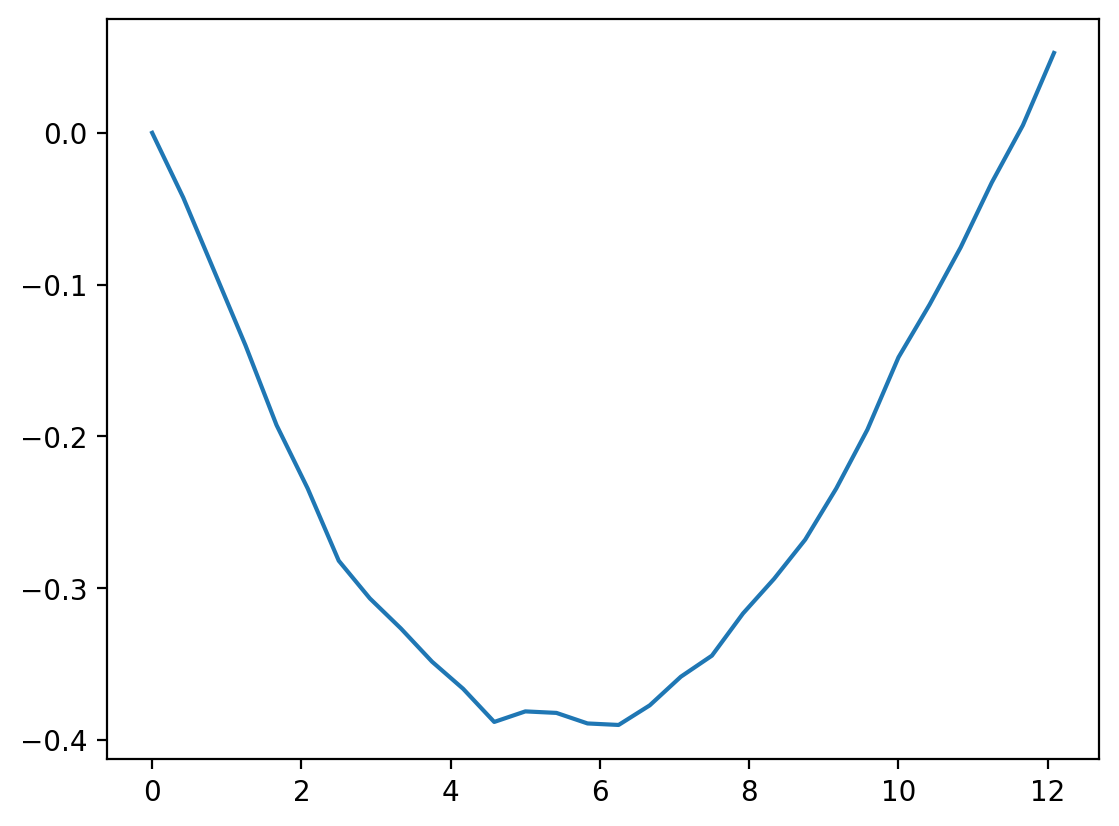

In [ ]:
import matplotlib.pyplot as plt

plt.plot(t[:30], y[:30])

In [ ]:
# display the results, dont show transformed parameter values
sorted([name + ":" + str(mp[name]) for name in mp.keys() if not name.endswith("_")])

NameError: name 'mp' is not defined

In [ ]:
dates = pd.date_range(start="2024-01-01", end="2024-03-30", freq="1H")
tnew = dates_to_idx(dates)[:, None]

print("Sampling gp predictions ...")
with model:
    mu_pred, cov_pred = gp.predict(tnew, point=mp)

# draw samples, and rescale
n_samples = 10
samples = pm.draw(pm.MvNormal.dist(mu=mu_pred, cov=cov_pred), draws=n_samples)
samples = samples * y_std + first_water

Sampling gp predictions ...


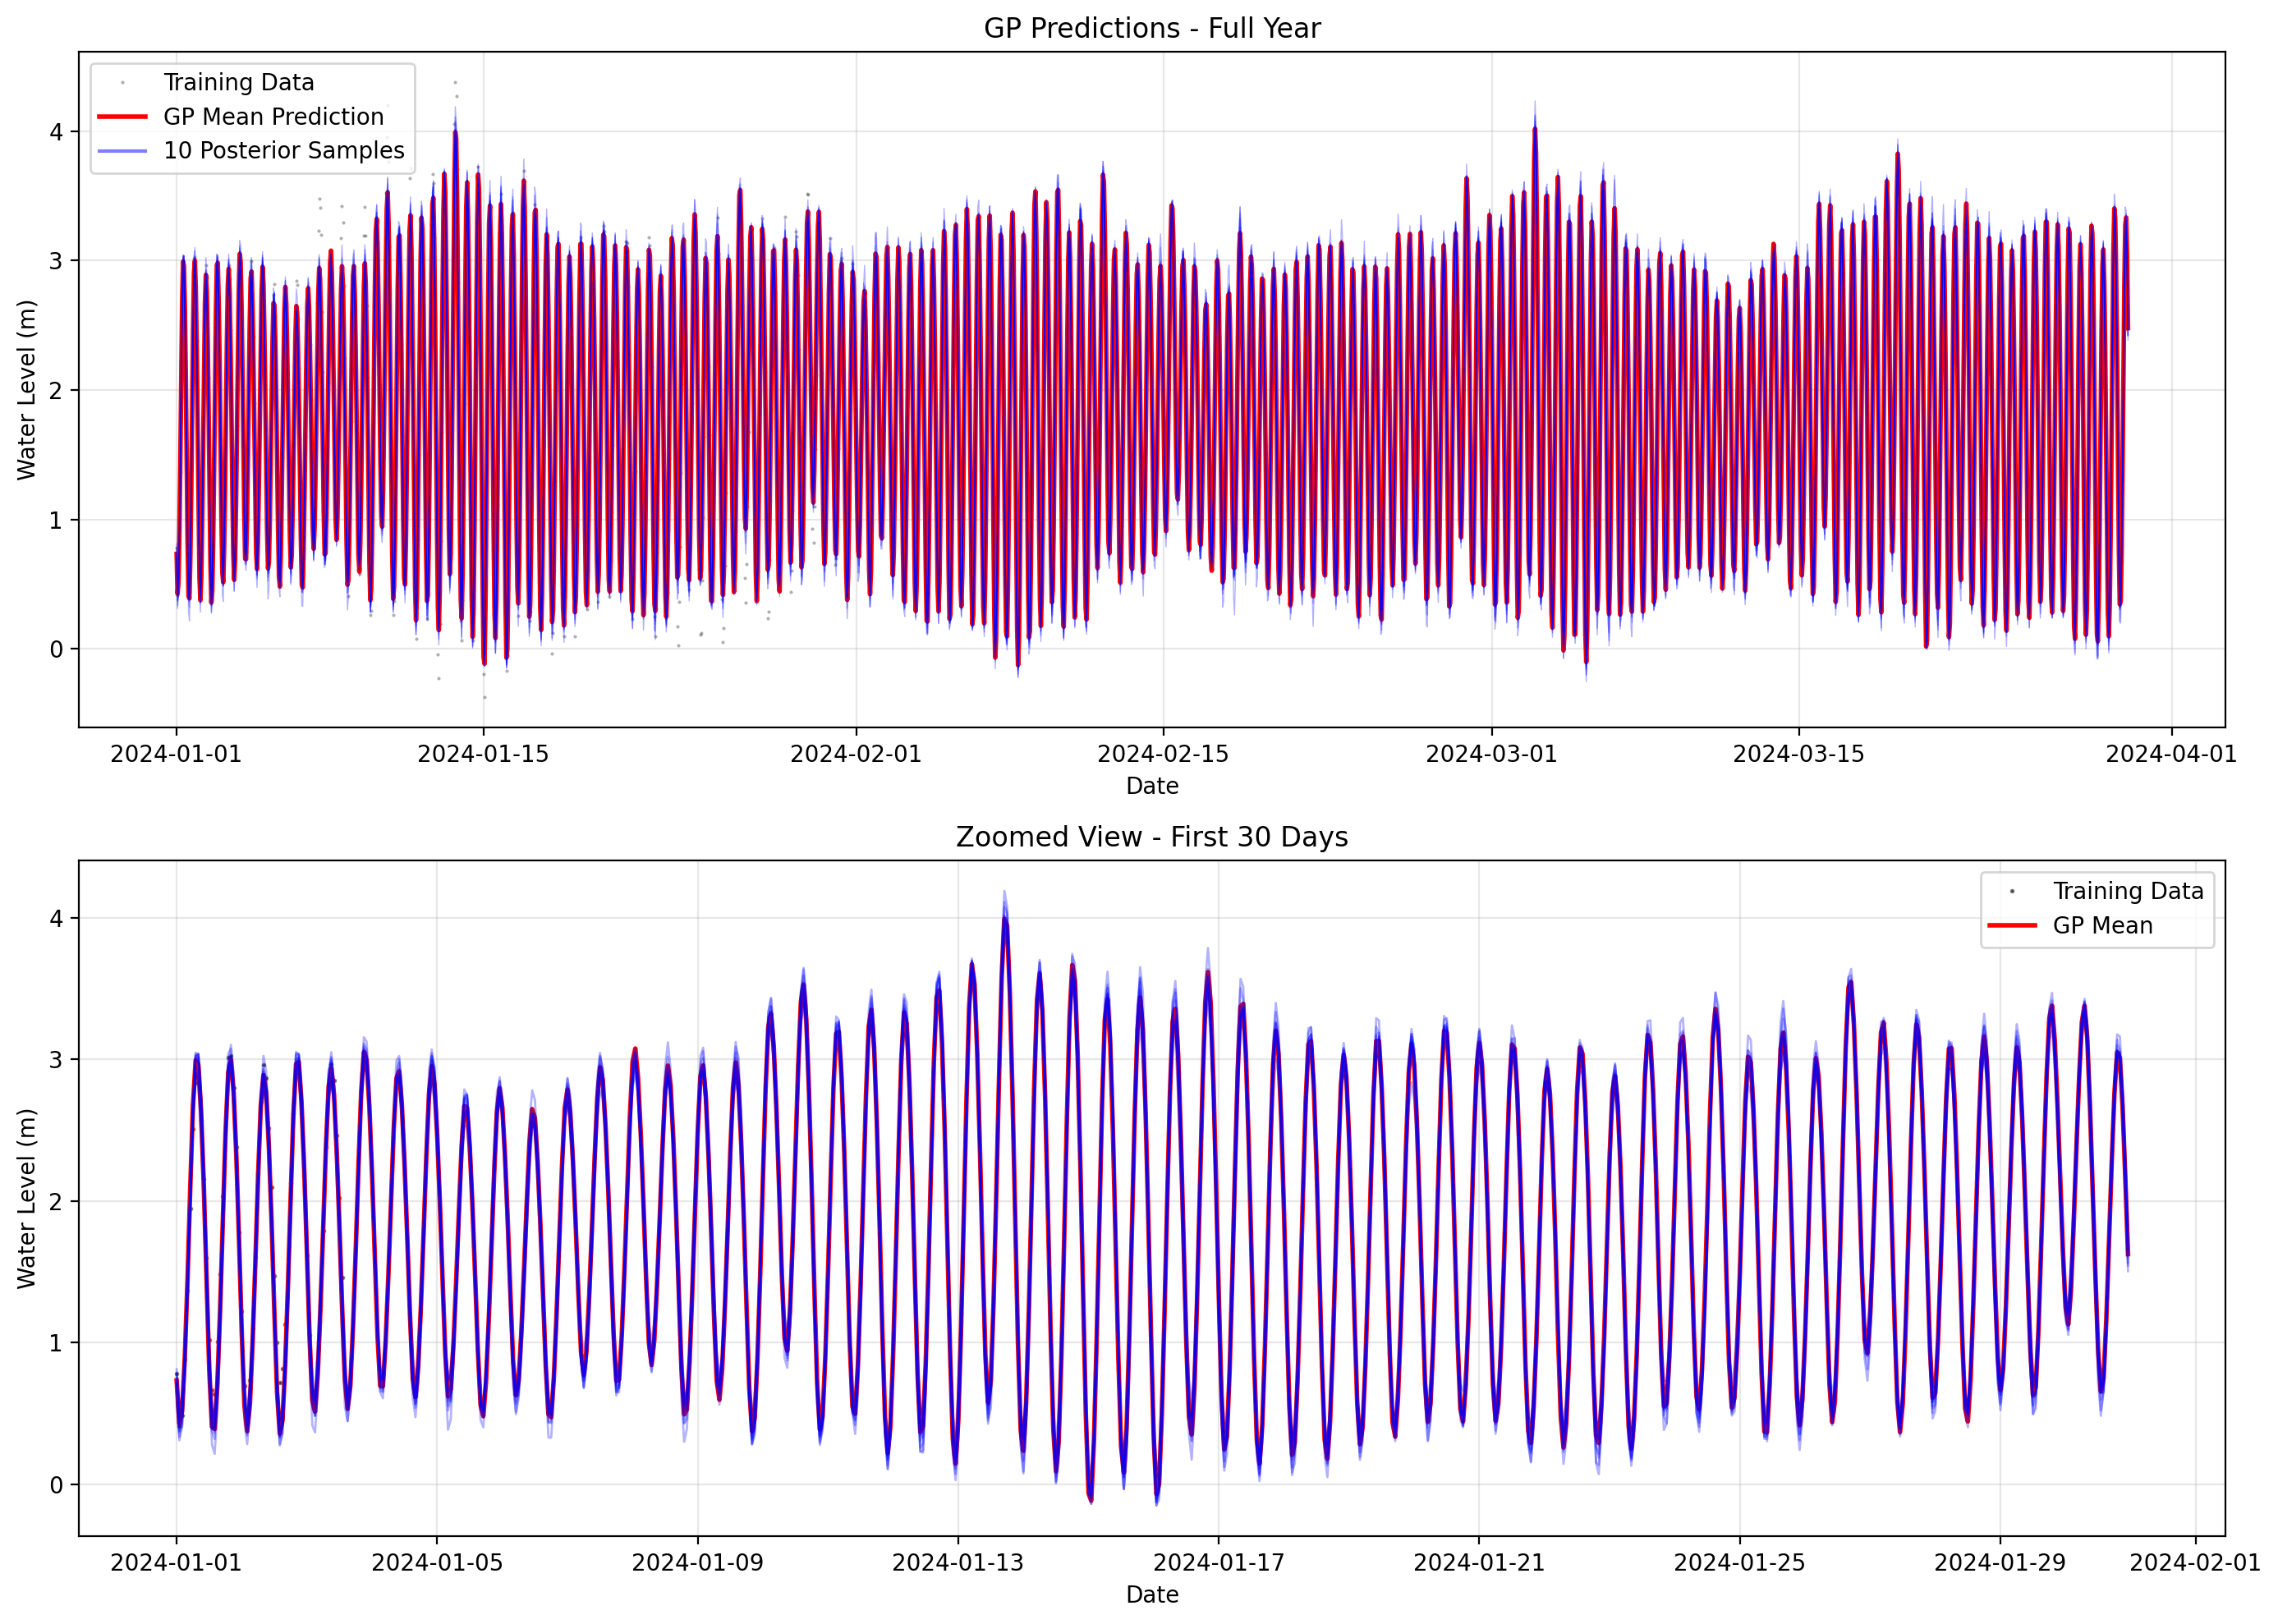

In [ ]:
import matplotlib.pyplot as plt

mu_pred_rescaled = mu_pred * y_std + first_water
y_original = y * y_std + first_water

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

ax1.plot(df_sub['time'], y_original, 'k.', alpha=0.3, markersize=1, label='Training Data')
ax1.plot(dates, mu_pred_rescaled, 'r-', linewidth=2, label='GP Mean Prediction')


for i in range(n_samples):
    ax1.plot(dates, samples[i, :], 'b-', alpha=0.3, linewidth=0.5)
ax1.plot([], [], 'b-', alpha=0.5, label=f'{n_samples} Posterior Samples')

ax1.set_xlabel('Date')
ax1.set_ylabel('Water Level (m)')
ax1.set_title('GP Predictions - Full Year')
ax1.legend()
ax1.grid(True, alpha=0.3)
zoom_days = 30  # First 30 days
zoom_mask = dates < dates[0] + pd.Timedelta(days=zoom_days)

ax2.plot(df_sub['time'][:len(y_original)//12], y_original[:len(y_original)//12],
         'k.', alpha=0.5, markersize=2, label='Training Data')
ax2.plot(dates[zoom_mask], mu_pred_rescaled[zoom_mask], 'r-', linewidth=2,
         label='GP Mean')

for i in range(n_samples):
    ax2.plot(dates[zoom_mask], samples[i, zoom_mask], 'b-', alpha=0.3, linewidth=1)

ax2.set_xlabel('Date')
ax2.set_ylabel('Water Level (m)')
ax2.set_title(f'Zoomed View - First {zoom_days} Days')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

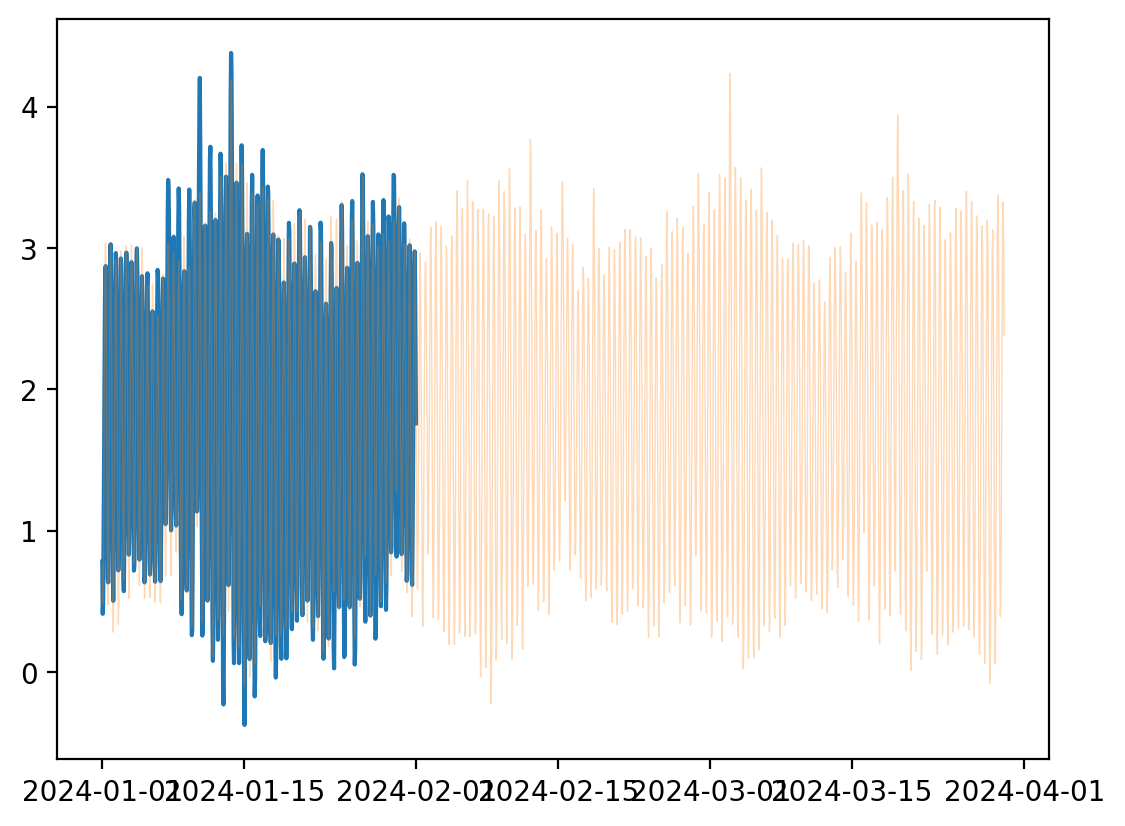

In [ ]:
plt.plot(df_sub['time'], df_sub['water_level'])
plt.plot(dates, samples[0, :], alpha=0.3, linewidth=0.5)

In [ ]:
df

time  water_level            t       y_n
0    2024-01-01 00:00:00        0.782     0.000000  0.000000
1    2024-01-01 00:06:00        0.739     0.416667 -0.042700
2    2024-01-01 00:12:00        0.690     0.833333 -0.091359
3    2024-01-01 00:18:00        0.641     1.250000 -0.140018
4    2024-01-01 00:24:00        0.588     1.666667 -0.192649
...                  ...          ...          ...       ...
7435 2024-01-31 23:30:00        1.471  3097.916667  0.684201
7436 2024-01-31 23:36:00        1.415  3098.333333  0.628591
7437 2024-01-31 23:42:00        1.359  3098.750000  0.572981
7438 2024-01-31 23:48:00        1.294  3099.166667  0.508434
7439 2024-01-31 23:54:00        1.229  3099.583333  0.443887

[7440 rows x 4 columns]

In [ ]:
def load_noaa_index(index_name):
  if index_name.startswith('nino'):
    url = f"https://psl.noaa.gov/data/timeseries/month/data/{index_name}.long.anom.data"
  else:
    url = f"https://psl.noaa.gov/data/correlation/{index_name}.data"
  df = pd.read_csv(url, delim_whitespace=True, header=None, skiprows=1)
  years = df.iloc[:, 0].values
  monthly_data = df.iloc[:, 1:13].values.flatten()

  dates = pd.date_range(start=f'{int(years[0])}-01-01',
                        periods=len(monthly_data), freq='MS')
  result = pd.DataFrame({
      'date': dates,
      'value': monthly_data
  })
  result['value'] = pd.to_numeric(result['value'], errors='coerce')
  result = result[(result['value'] != '-99.99') & (result['value'] != -99.99)]
  result = result.dropna()
  return result
base_url = "https://psl.noaa.gov/data/correlation/"
nino34 = load_noaa_index("nino34")
nino12 = load_noaa_index('nino12')
nino3 = load_noaa_index('nino3')
nino4 = load_noaa_index('nino4')
soi = load_noaa_index('soi')

In [ ]:
df_new = pd.merge(nino3, soi, on='date')
df_new.columns = ['date', 'nino3', 'soi']
df_new.corr()

date     nino3       soi
date   1.000000  0.111032  0.018606
nino3  0.111032  1.000000 -0.651475
soi    0.018606 -0.651475  1.000000

In [ ]:
df_new = pd.merge(df_new, nino4)
df_new.columns = ['date', 'nino3', 'soi', 'nino4']
df_new = pd.merge(df_new, nino34)
df_new.columns = ['date', 'nino3', 'soi', 'nino4', 'nino34']
df_new = pd.merge(df_new, nino12)
df_new.columns = ['date', 'nino3', 'soi', 'nino4', 'nino34', 'nino12']
df_new

date  nino3  soi  nino4  nino34  nino12
0   1951-01-01  -0.72  2.5  -1.26   -1.13    0.14
1   1951-02-01  -0.43  1.5  -0.96   -0.74   -0.56
2   1951-03-01  -0.63 -0.2  -0.77   -0.77   -0.22
3   1951-04-01   0.00 -0.5  -0.53   -0.17    0.30
4   1951-05-01  -0.12 -1.1  -0.19   -0.10    0.75
..         ...    ...  ...    ...     ...     ...
891 2025-04-01   0.05  0.9  -0.09   -0.08    0.04
892 2025-05-01  -0.12  0.7   0.02   -0.08    0.21
893 2025-06-01   0.03  0.5   0.14    0.01    0.44
894 2025-07-01   0.07  1.0   0.05   -0.03    0.29
895 2025-08-01  -0.02  0.7   0.06   -0.11    0.04

[896 rows x 6 columns]

In [ ]:
df_new.corr()

date     nino3       soi     nino4    nino34    nino12
date    1.000000  0.111032  0.018606  0.210109  0.073588  0.030193
nino3   0.111032  1.000000 -0.651475  0.773393  0.945166  0.845938
soi     0.018606 -0.651475  1.000000 -0.685310 -0.720446 -0.476883
nino4   0.210109  0.773393 -0.685310  1.000000  0.908408  0.484454
nino34  0.073588  0.945166 -0.720446  0.908408  1.000000  0.684243
nino12  0.030193  0.845938 -0.476883  0.484454  0.684243  1.000000

In [ ]:
from sklearn.preprocessing import StandardScaler

t = (df_new['date'] - df_new['date'].min()).dt.days / 365.0

X = np.column_stack([
    t[:700],
    df_new['soi'].values[:700]
])
y = df_new['nino34'].values[:700]
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

In [ ]:
with pm.Model() as model:
  l = pm.Gamma('l', alpha=2, beta=1, shape=2)
  cov_ard = pm.gp.cov.ExpQuad(2, ls=l)

  period = pm.Gamma('period', alpha=8, beta=2, initval=3.5)
  l_per = pm.Gamma('l_per', alpha=2, beta=1)
  cov_per = pm.gp.cov.Periodic(2, period, ls=l_per, active_dims=[0])

  n = pm.HalfCauchy('n', beta=2)
  cov_total = n**2 * (cov_per + cov_ard)

  sigma = pm.HalfNormal('sigma', sigma=0.5)

  gp = pm.gp.Marginal(cov_func=cov_total)
  y_ = gp.marginal_likelihood('y', X=X_scaled, y=y_scaled, sigma=sigma)
  mp = pm.find_MAP(include_transformed=True)

Output()

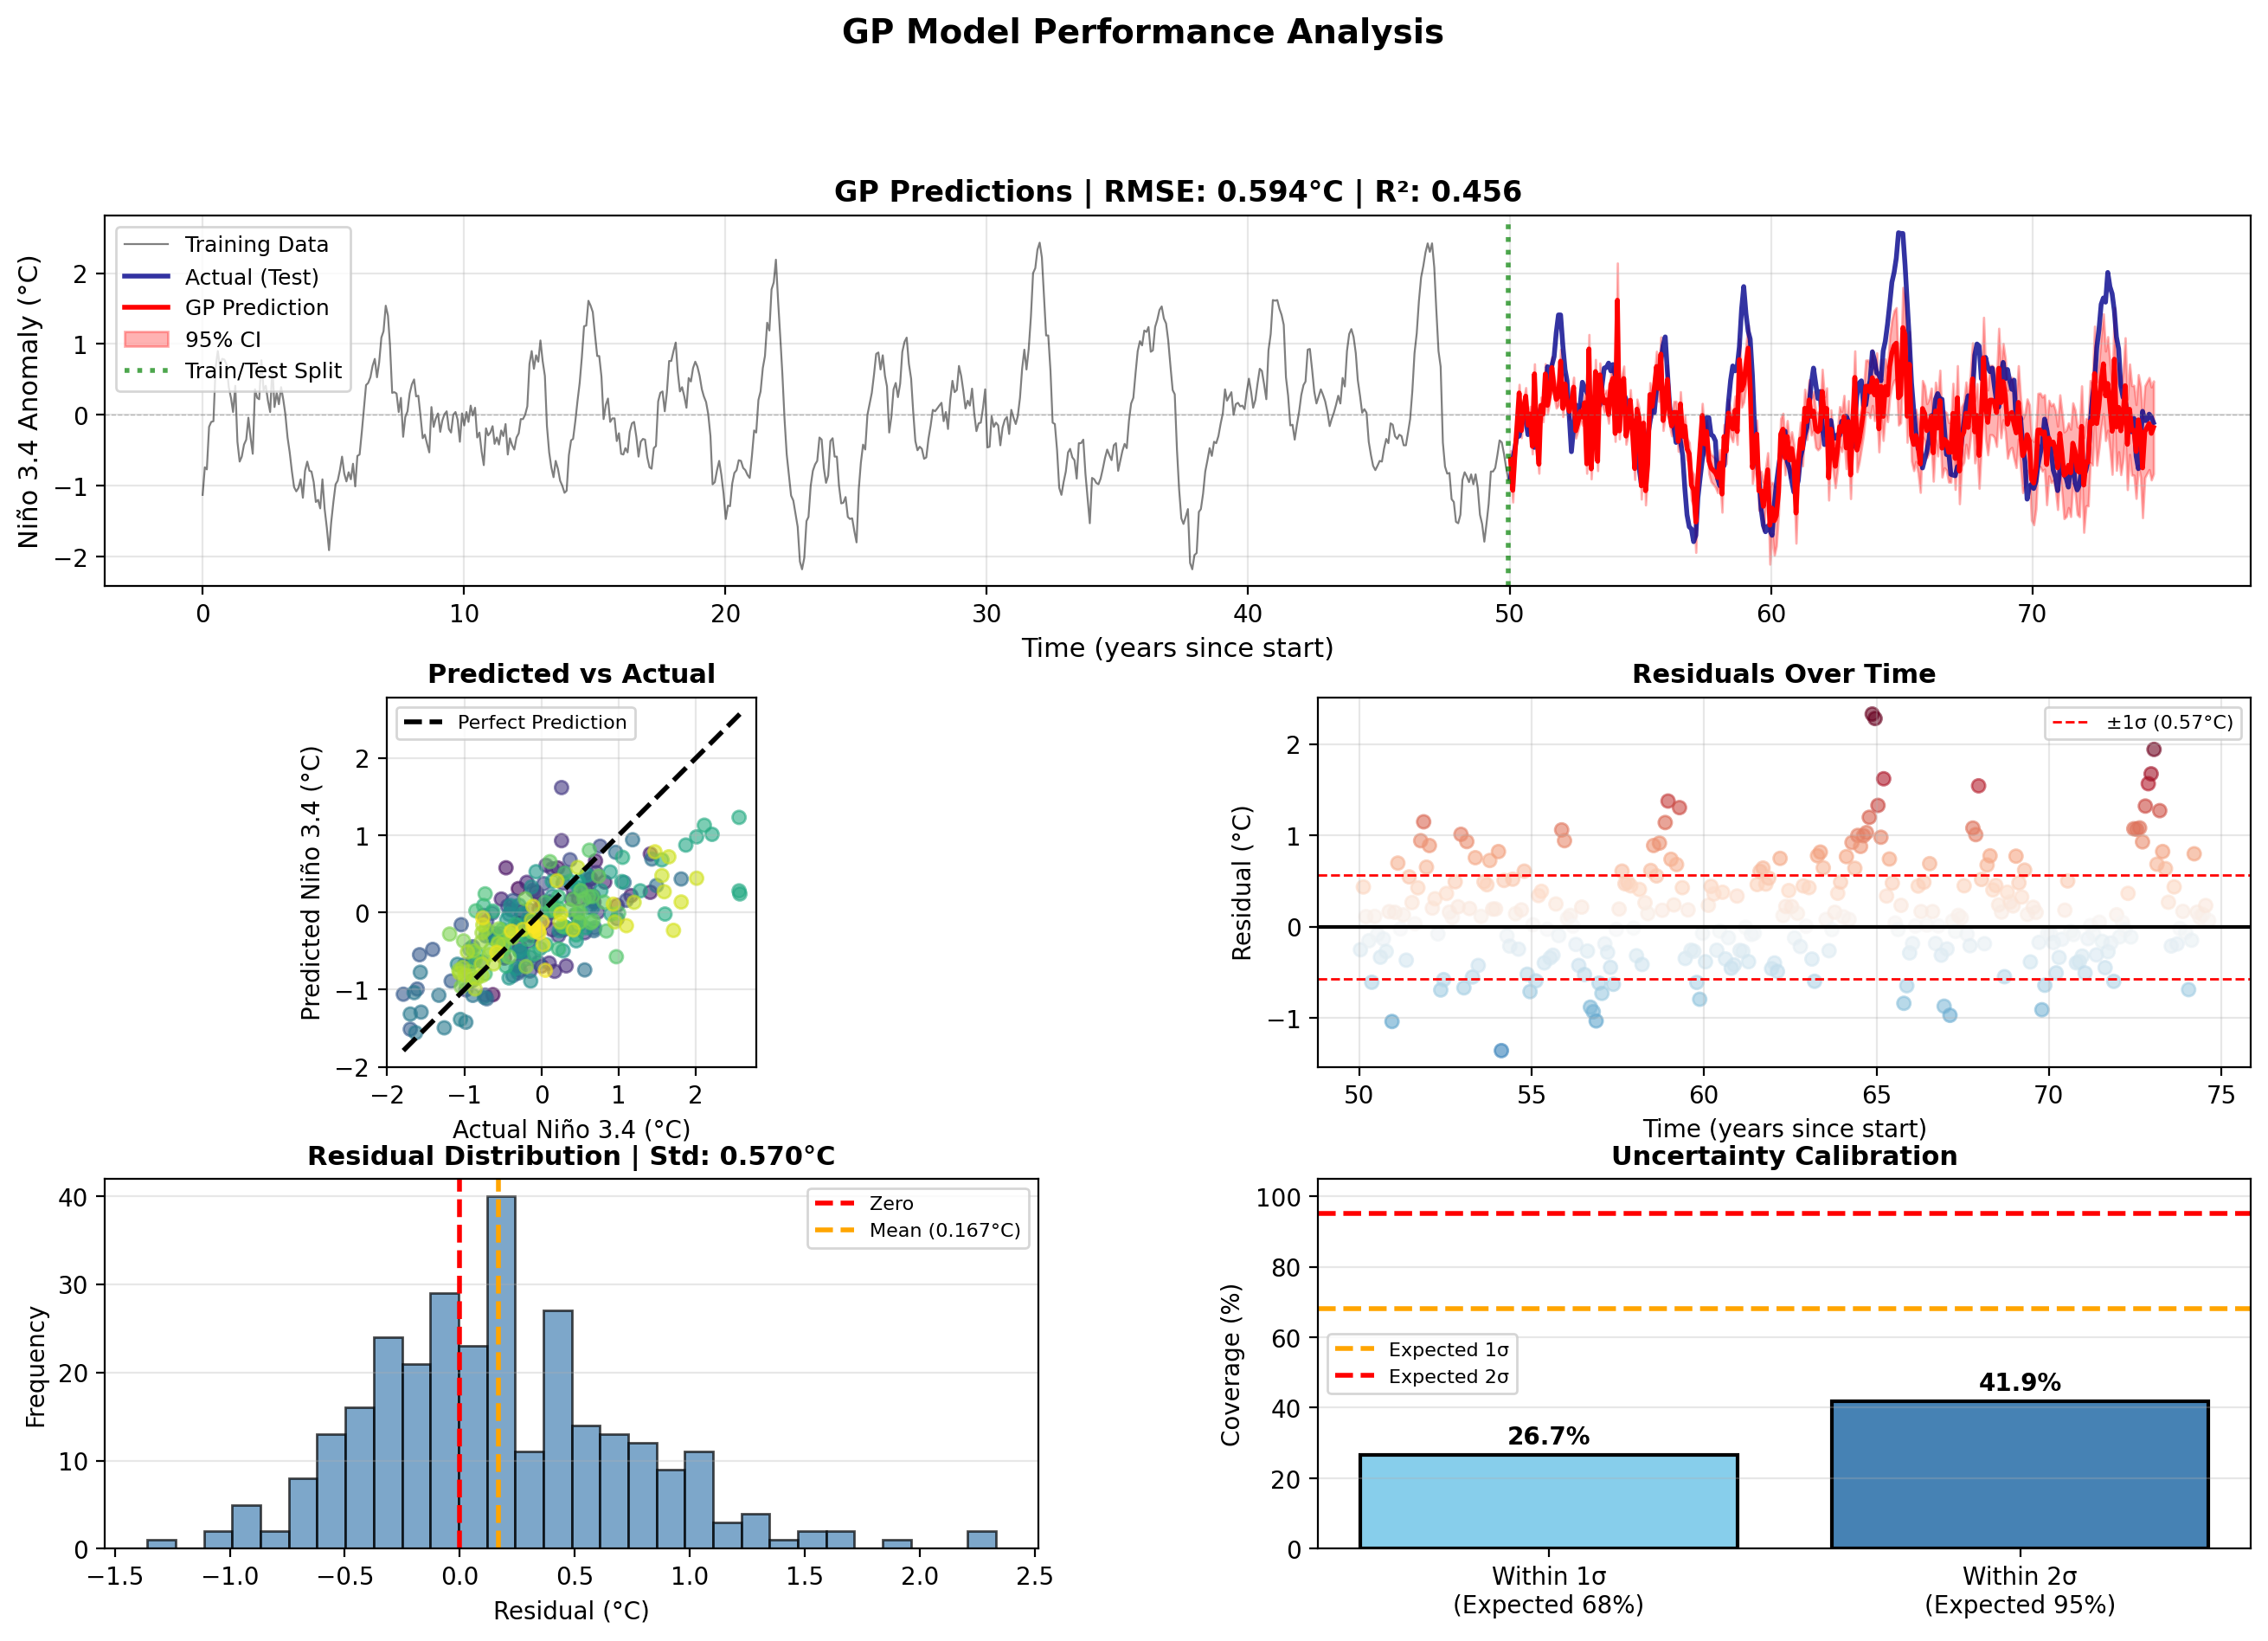

MODEL PERFORMANCE METRICS
Root Mean Squared Error (RMSE): 0.5944°C
Mean Absolute Error (MAE):      0.4514°C
R² Score:                        0.4564
Mean Residual (Bias):            0.1671°C
Std of Residuals:                0.5704°C

UNCERTAINTY CALIBRATION
Coverage within 1σ: 26.7% (Expected: 68%)
Coverage within 2σ: 41.9% (Expected: 95%)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# ===== DEFINE TEST DATA FIRST =====
t_test = t[600:]
y_test = df_new['nino34'].values[600:]
soi_test = df_new['soi'].values[600:]

# If you have DMI in your model, include it:
# dmi_test = df_new['dmi'].values[600:]
# X_test = np.column_stack([t_test, soi_test, dmi_test])

X_test = np.column_stack([t_test, soi_test])
X_test_scaled = scaler_x.transform(X_test)

# Get predictions
with model:
    mu_pred, cov_pred = gp.predict(X_test_scaled, point=mp)

n_samples = 100  # Increase for better uncertainty estimates
samples = pm.draw(pm.MvNormal.dist(mu=mu_pred, cov=cov_pred), draws=n_samples)
samples_rescaled = scaler_y.inverse_transform(samples.T).T
mean_pred = samples_rescaled.mean(axis=0)
std_pred = samples_rescaled.std(axis=0)

# Training data
t_train = t[:600]
y_train = df_new['nino34'].values[:600]

# ===== NOW CALCULATE METRICS =====
rmse = np.sqrt(mean_squared_error(y_test, mean_pred))
r2 = r2_score(y_test, mean_pred)
residuals = y_test - mean_pred

# ===== CREATE VISUALIZATION =====
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Main prediction plot
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(t_train, y_train, 'k-', alpha=0.5, linewidth=0.8, label='Training Data')
ax1.plot(t_test, y_test, 'darkblue', alpha=0.8, linewidth=2, label='Actual (Test)', linestyle='-')
ax1.plot(t_test, mean_pred, 'r-', linewidth=2, label='GP Prediction')
ax1.fill_between(t_test, mean_pred - 2*std_pred, mean_pred + 2*std_pred,
                 alpha=0.3, color='red', label='95% CI')
ax1.axvline(x=t_train.iloc[-1], color='green', linestyle=':', linewidth=2,
            label='Train/Test Split', alpha=0.7)
ax1.axhline(y=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax1.set_xlabel('Time (years since start)', fontsize=11)
ax1.set_ylabel('Niño 3.4 Anomaly (°C)', fontsize=11)
ax1.set_title(f'GP Predictions | RMSE: {rmse:.3f}°C | R²: {r2:.3f}', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# 2. Scatter plot: Predicted vs Actual
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(y_test, mean_pred, alpha=0.6, s=30, c=t_test, cmap='viridis')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'k--', linewidth=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Niño 3.4 (°C)', fontsize=10)
ax2.set_ylabel('Predicted Niño 3.4 (°C)', fontsize=10)
ax2.set_title('Predicted vs Actual', fontsize=11, fontweight='bold')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal', adjustable='box')

# 3. Residuals over time
ax3 = fig.add_subplot(gs[1, 1])
ax3.scatter(t_test, residuals, alpha=0.6, s=30, c=residuals, cmap='RdBu_r',
            vmin=-2, vmax=2)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
ax3.axhline(y=np.std(residuals), color='red', linestyle='--', linewidth=1,
            label=f'±1σ ({np.std(residuals):.2f}°C)')
ax3.axhline(y=-np.std(residuals), color='red', linestyle='--', linewidth=1)
ax3.set_xlabel('Time (years since start)', fontsize=10)
ax3.set_ylabel('Residual (°C)', fontsize=10)
ax3.set_title('Residuals Over Time', fontsize=11, fontweight='bold')
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

# 4. Residual histogram
ax4 = fig.add_subplot(gs[2, 0])
ax4.hist(residuals, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
ax4.axvline(x=np.mean(residuals), color='orange', linestyle='--', linewidth=2,
            label=f'Mean ({np.mean(residuals):.3f}°C)')
ax4.set_xlabel('Residual (°C)', fontsize=10)
ax4.set_ylabel('Frequency', fontsize=10)
ax4.set_title(f'Residual Distribution | Std: {np.std(residuals):.3f}°C',
              fontsize=11, fontweight='bold')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3, axis='y')

# 5. Uncertainty calibration
ax5 = fig.add_subplot(gs[2, 1])
within_1sigma = np.abs(residuals) <= std_pred
within_2sigma = np.abs(residuals) <= 2*std_pred

coverage_1sigma = np.mean(within_1sigma) * 100
coverage_2sigma = np.mean(within_2sigma) * 100

ax5.bar(['Within 1σ\n(Expected 68%)', 'Within 2σ\n(Expected 95%)'],
        [coverage_1sigma, coverage_2sigma],
        color=['skyblue', 'steelblue'], edgecolor='black', linewidth=1.5)
ax5.axhline(y=68, color='orange', linestyle='--', linewidth=2, label='Expected 1σ')
ax5.axhline(y=95, color='red', linestyle='--', linewidth=2, label='Expected 2σ')
ax5.set_ylabel('Coverage (%)', fontsize=10)
ax5.set_title('Uncertainty Calibration', fontsize=11, fontweight='bold')
ax5.set_ylim([0, 105])
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3, axis='y')

ax5.text(0, coverage_1sigma + 3, f'{coverage_1sigma:.1f}%',
         ha='center', fontsize=10, fontweight='bold')
ax5.text(1, coverage_2sigma + 3, f'{coverage_2sigma:.1f}%',
         ha='center', fontsize=10, fontweight='bold')

plt.suptitle('GP Model Performance Analysis', fontsize=14, fontweight='bold', y=0.995)
plt.show()

# Print metrics
print("="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}°C")
print(f"Mean Absolute Error (MAE):      {np.mean(np.abs(residuals)):.4f}°C")
print(f"R² Score:                        {r2:.4f}")
print(f"Mean Residual (Bias):            {np.mean(residuals):.4f}°C")
print(f"Std of Residuals:                {np.std(residuals):.4f}°C")
print("\nUNCERTAINTY CALIBRATION")
print("="*60)
print(f"Coverage within 1σ: {coverage_1sigma:.1f}% (Expected: 68%)")
print(f"Coverage within 2σ: {coverage_2sigma:.1f}% (Expected: 95%)")

In [ ]:
len(df_new['soi'].values)

896

In [ ]:
len(tnew)

884

In [ ]:
t_test = t[600:]
y_test = df_new['nino34'].values[600:]
soi_test = df_new['soi'].values[600:]

X_test = np.column_stack([
    t_test,
    soi_test
])

X_test_scaled = scaler_x.transform(X_test)
with model:
    mu_pred, cov_pred = gp.predict(X_test_scaled, point=mp)

n_samples = 10
samples = pm.draw(pm.MvNormal.dist(mu=mu_pred, cov=cov_pred), draws=n_samples)
samples_rescaled = scaler_y.inverse_transform(samples.T).T
mean_pred = samples_rescaled.mean(axis=0)
std_pred = samples_rescaled.std(axis=0)

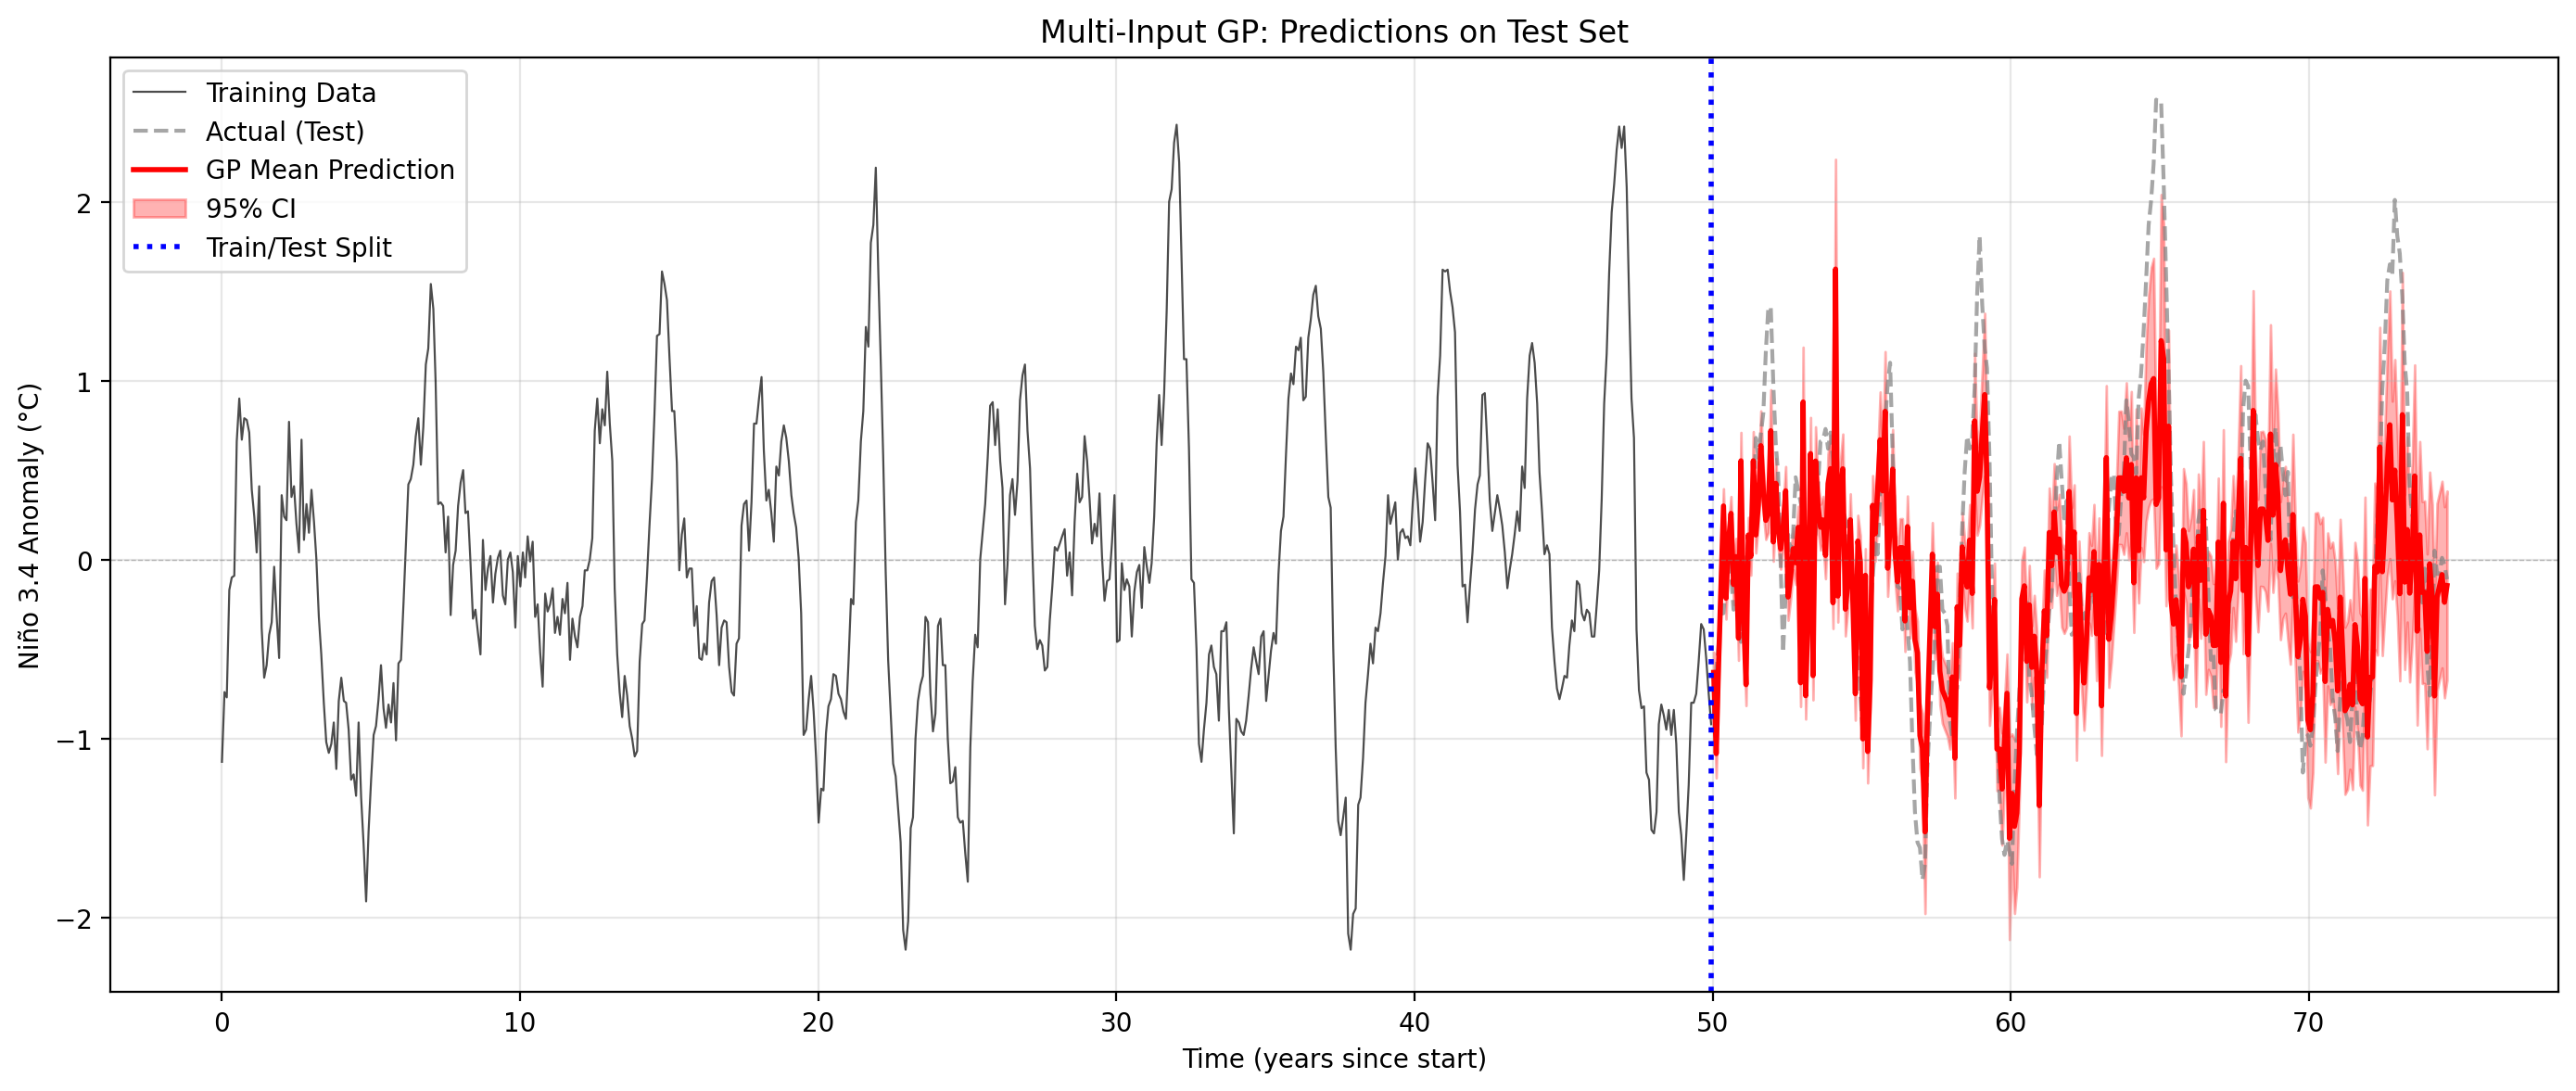

In [ ]:
import matplotlib.pyplot as plt
t_train = t[:600]
y_train = df_new['nino34'].values[:600]

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(t_train, y_train, 'k-', alpha=0.7, linewidth=0.8, label='Training Data')

ax.plot(t_test, y_test, 'gray', alpha=0.7, linewidth=1.5, label='Actual (Test)', linestyle='--')

ax.plot(t_test, mean_pred, 'r-', linewidth=2, label='GP Mean Prediction')

ax.fill_between(
    t_test,
    mean_pred - 2*std_pred,
    mean_pred + 2*std_pred,
    alpha=0.3,
    color='red',
    label='95% CI'
)
ax.axvline(x=t_train.iloc[-1], color='blue', linestyle=':', linewidth=2, label='Train/Test Split')

ax.set_xlabel('Time (years since start)')
ax.set_ylabel('Niño 3.4 Anomaly (°C)')
ax.set_title('Multi-Input GP: Predictions on Test Set')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import requests

url = "https://psl.noaa.gov/data/timeseries/month/data/soi.long.data"
response = requests.get(url)

# Print first 30 lines
# print("First 30 lines of the file:")
# print("="*60)
# for i, line in enumerate(response.text.split('\n')[:30]):
#     print(f"{i:3d}: {line}")

df = pd.read_csv(url, delim_whitespace=True, header=None, skiprows=[1, -1])

ParserError: Error tokenizing data. C error: Expected 2 fields in line 3, saw 13


In [ ]:
import requests

url = "https://psl.noaa.gov/data/timeseries/month/data/nino34.long.anom.data"
response = requests.get(url)

# Print first 30 lines
print("First 30 lines of the file:")
print("="*60)
for i, line in enumerate(response.text.split('\n')[:30]):
    print(f"{i:3d}: {line}")

First 30 lines of the file:
  0:           1870        2025
  1:  1870    -1.00   -1.20   -0.83   -0.81   -1.27   -1.08   -1.04   -0.88   -0.53   -0.92   -0.79   -0.79
  2:  1871    -0.25   -0.58   -0.43   -0.50   -0.71   -0.53   -0.60   -0.33   -0.24   -0.33   -0.31   -0.58
  3:  1872    -0.72   -0.62   -0.50   -0.77   -0.62   -0.52   -0.32   -0.85   -1.02   -0.94   -0.79   -0.88
  4:  1873    -0.78   -1.01   -1.31   -0.67   -0.53   -0.48   -0.58   -0.39   -0.34   -0.78   -0.77   -0.70
  5:  1874    -0.93   -1.06   -1.40   -0.94   -0.86   -0.72   -1.00   -1.05   -1.13   -1.25   -1.33   -1.14
  6:  1875    -0.71   -0.37   -0.59   -0.87   -1.09   -0.76   -0.85   -0.81   -0.91   -0.83   -0.64   -0.75
  7:  1876    -0.95   -1.20   -1.13   -1.18   -1.08   -0.43   -0.34   -0.16   -0.02    0.11    0.15    0.23
  8:  1877     0.35    0.46    0.52    0.50    0.76    0.98    1.42    1.54    1.75    1.95    2.08    2.49
  9:  1878     2.41    2.43    1.31    0.92    0.82    0.92    0.25   -0.11 

In [ ]:
dmi_url = "https://psl.noaa.gov/data/timeseries/month/data/dmi.had.long.csv"
dmi_df = pd.read_csv(dmi_url, skiprows=1, names=['date', 'dmi'])
dmi_df['date'] = pd.to_datetime(dmi_df['date'])
dmi_df['dmi'] = dmi_df['dmi'].replace(-9999, np.nan)
df_new = df_new.merge(dmi_df, on='date', how='left')

DMI data from 1870-01-01 00:00:00 to 2025-12-01 00:00:00
Missing values: 8

After merge:
Total rows: 896
DMI available: 892
Date range: 1951-01-01 00:00:00 to 2025-08-01 00:00:00

Sample of merged data:
        date  nino34  soi    dmi
0 1951-01-01   -1.13  2.5  0.256
1 1951-02-01   -0.74  1.5  0.211
2 1951-03-01   -0.77 -0.2  0.259
3 1951-04-01   -0.17 -0.5 -0.513
4 1951-05-01   -0.10 -1.1 -0.138
5 1951-06-01   -0.09  0.3 -0.190
6 1951-07-01    0.66 -1.7 -0.220
7 1951-08-01    0.90 -0.4  0.124
8 1951-09-01    0.67 -1.8 -0.005
9 1951-10-01    0.79 -1.6 -0.168


In [ ]:
from sklearn.preprocessing import StandardScaler
import pymc as pm
import numpy as np

t = (df_new['date'] - df_new['date'].min()).dt.days / 365.0

X = np.column_stack([
    t[:700],
    df_new['soi'].values[:700],
    df_new['dmi'].values[:700]
])
y = df_new['nino34'].values[:700]

# Scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

with pm.Model() as model:
    # 1. Long-term trend component (slow variation)
    l_trend = pm.Gamma('l_trend', alpha=2, beta=0.3, shape=3)  # Long lengthscales
    cov_trend = pm.gp.cov.Matern52(3, ls=l_trend)

    # 2. Short-term dynamics (inter-variable correlations)
    l_short = pm.Gamma('l_short', alpha=2, beta=2, shape=3)  # Shorter lengthscales
    cov_short = pm.gp.cov.Matern52(3, ls=l_short)

    # 3. Periodic component (ENSO cycle on time dimension only)
    period = pm.Gamma('period', alpha=8, beta=2, initval=3.5)  # ~3.5 year ENSO cycle
    l_per = pm.Gamma('l_per', alpha=2, beta=1)
    cov_per = pm.gp.cov.Periodic(3, period, ls=l_per, active_dims=[0])

    eta_per = pm.HalfCauchy('eta_per', beta=2)  # Scale for periodic × short-term
    eta_trend = pm.HalfCauchy('eta_trend', beta=1)  # Scale for trend

    cov_total = eta_per**2 * (cov_per * cov_short) + eta_trend**2 * cov_trend

    sigma = pm.HalfNormal('sigma', sigma=0.5)

    gp = pm.gp.Marginal(cov_func=cov_total)
    y_ = gp.marginal_likelihood('y', X=X_scaled, y=y_scaled, sigma=sigma)

    mp = pm.find_MAP(include_transformed=True)

print("Model parameters:")
for key, value in mp.items():
    if not key.endswith('_'):
        print(f"{key}: {value}")

Output()

Model parameters:
l_trend: [5.67660255 3.38717473 6.19536066]
l_short: [0.05871016 2.96294274 6.01281642]
period: 3.488105135898651
l_per: 1.669630556019211
eta_per: 0.19522780406739432
eta_trend: 1.6477493212793204
sigma: 0.5580288764904168


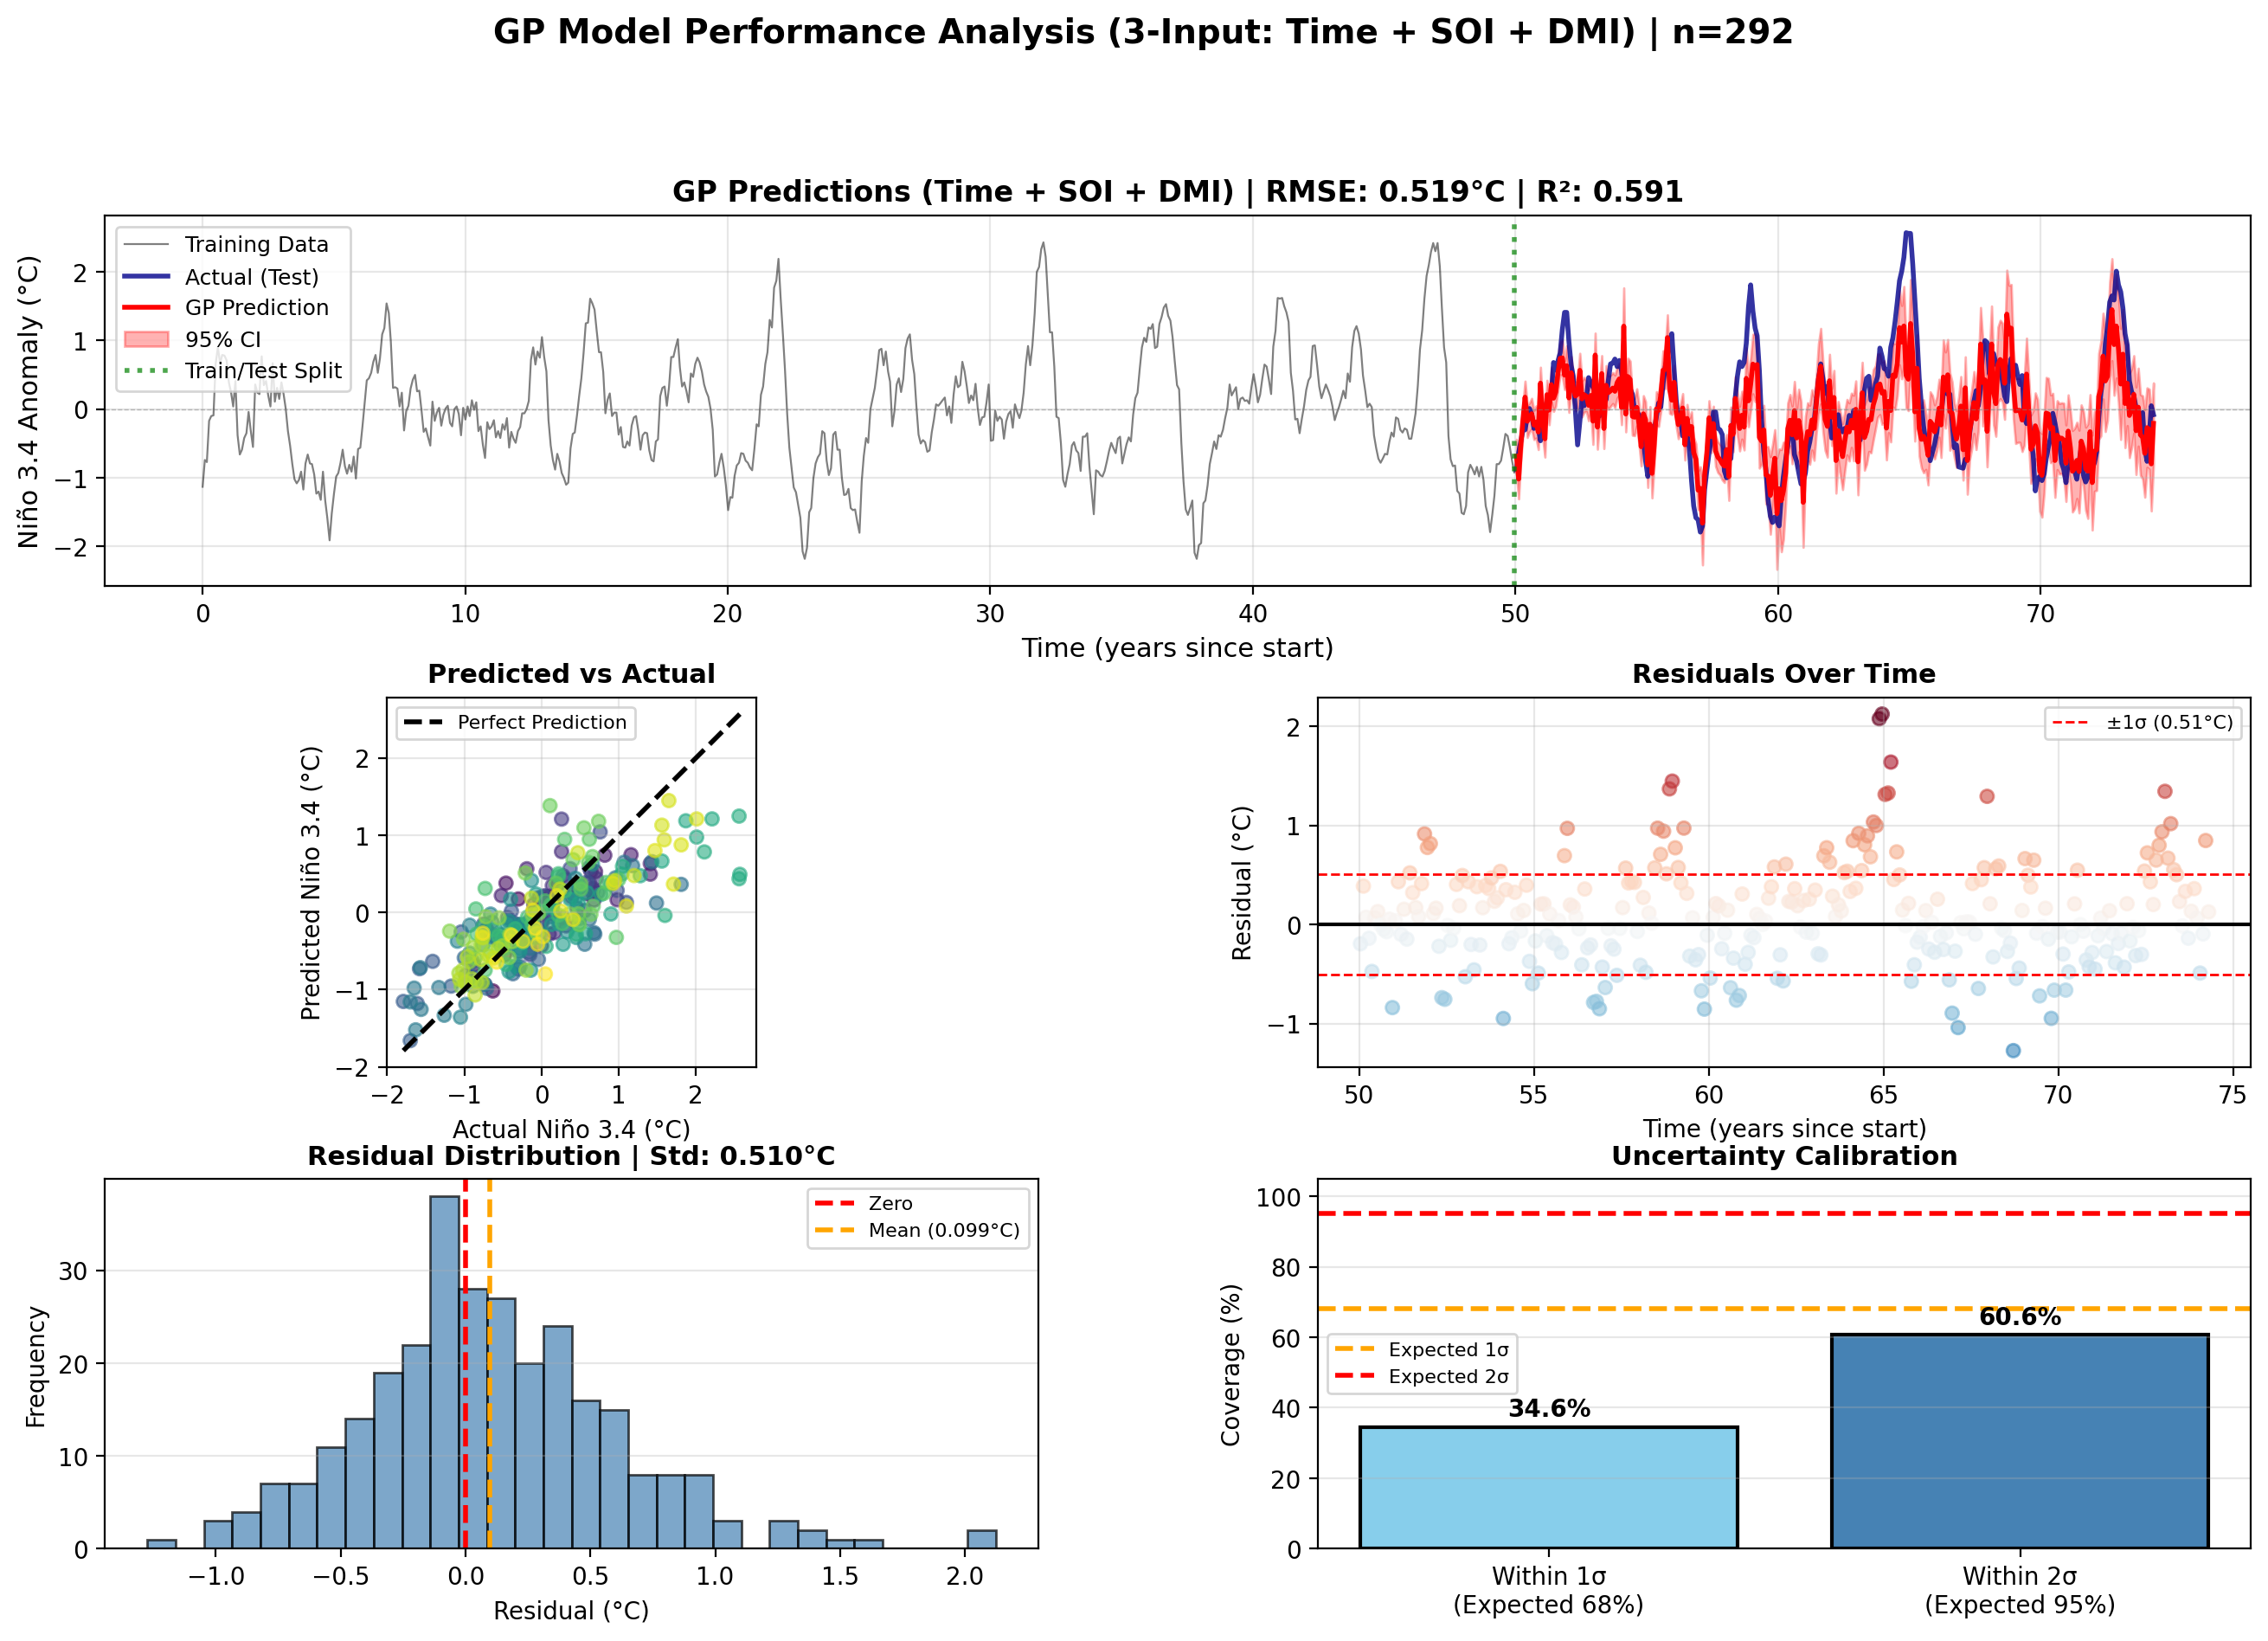

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
t_test_full = t[600:]
y_test_full = df_new['nino34'].values[600:]
soi_test_full = df_new['soi'].values[600:]
dmi_test_full = df_new['dmi'].values[600:]

valid_mask = ~(np.isnan(dmi_test_full) | np.isnan(soi_test_full) | np.isnan(y_test_full))

t_test = t_test_full[valid_mask]
y_test = y_test_full[valid_mask]
soi_test = soi_test_full[valid_mask]
dmi_test = dmi_test_full[valid_mask]

X_test = np.column_stack([t_test, soi_test, dmi_test])
X_test_scaled = scaler_x.transform(X_test)

with model:
    mu_pred, cov_pred = gp.predict(X_test_scaled, point=mp)

n_samples = 100
samples = pm.draw(pm.MvNormal.dist(mu=mu_pred, cov=cov_pred), draws=n_samples)
samples_rescaled = scaler_y.inverse_transform(samples.T).T
mean_pred = samples_rescaled.mean(axis=0)
std_pred = samples_rescaled.std(axis=0)
t_train = t[:600]
y_train = df_new['nino34'].values[:600]

rmse = np.sqrt(mean_squared_error(y_test, mean_pred))
r2 = r2_score(y_test, mean_pred)
residuals = y_test - mean_pred

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, :])
ax1.plot(t_train, y_train, 'k-', alpha=0.5, linewidth=0.8, label='Training Data')
ax1.plot(t_test, y_test, 'darkblue', alpha=0.8, linewidth=2, label='Actual (Test)', linestyle='-')
ax1.plot(t_test, mean_pred, 'r-', linewidth=2, label='GP Prediction')
ax1.fill_between(t_test, mean_pred - 2*std_pred, mean_pred + 2*std_pred,
                 alpha=0.3, color='red', label='95% CI')
ax1.axvline(x=t_train.iloc[-1], color='green', linestyle=':', linewidth=2,
            label='Train/Test Split', alpha=0.7)
ax1.axhline(y=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax1.set_xlabel('Time (years since start)', fontsize=11)
ax1.set_ylabel('Niño 3.4 Anomaly (°C)', fontsize=11)
ax1.set_title(f'GP Predictions (Time + SOI + DMI) | RMSE: {rmse:.3f}°C | R²: {r2:.3f}',
              fontsize=12, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(y_test, mean_pred, alpha=0.6, s=30, c=t_test, cmap='viridis')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'k--', linewidth=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Niño 3.4 (°C)', fontsize=10)
ax2.set_ylabel('Predicted Niño 3.4 (°C)', fontsize=10)
ax2.set_title('Predicted vs Actual', fontsize=11, fontweight='bold')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal', adjustable='box')

ax3 = fig.add_subplot(gs[1, 1])
ax3.scatter(t_test, residuals, alpha=0.6, s=30, c=residuals, cmap='RdBu_r',
            vmin=-2, vmax=2)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
ax3.axhline(y=np.std(residuals), color='red', linestyle='--', linewidth=1,
            label=f'±1σ ({np.std(residuals):.2f}°C)')
ax3.axhline(y=-np.std(residuals), color='red', linestyle='--', linewidth=1)
ax3.set_xlabel('Time (years since start)', fontsize=10)
ax3.set_ylabel('Residual (°C)', fontsize=10)
ax3.set_title('Residuals Over Time', fontsize=11, fontweight='bold')
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

ax4 = fig.add_subplot(gs[2, 0])
ax4.hist(residuals, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
ax4.axvline(x=np.mean(residuals), color='orange', linestyle='--', linewidth=2,
            label=f'Mean ({np.mean(residuals):.3f}°C)')
ax4.set_xlabel('Residual (°C)', fontsize=10)
ax4.set_ylabel('Frequency', fontsize=10)
ax4.set_title(f'Residual Distribution | Std: {np.std(residuals):.3f}°C',
              fontsize=11, fontweight='bold')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3, axis='y')

ax5 = fig.add_subplot(gs[2, 1])
within_1sigma = np.abs(residuals) <= std_pred
within_2sigma = np.abs(residuals) <= 2*std_pred

coverage_1sigma = np.mean(within_1sigma) * 100
coverage_2sigma = np.mean(within_2sigma) * 100

ax5.bar(['Within 1σ\n(Expected 68%)', 'Within 2σ\n(Expected 95%)'],
        [coverage_1sigma, coverage_2sigma],
        color=['skyblue', 'steelblue'], edgecolor='black', linewidth=1.5)
ax5.axhline(y=68, color='orange', linestyle='--', linewidth=2, label='Expected 1σ')
ax5.axhline(y=95, color='red', linestyle='--', linewidth=2, label='Expected 2σ')
ax5.set_ylabel('Coverage (%)', fontsize=10)
ax5.set_title('Uncertainty Calibration', fontsize=11, fontweight='bold')
ax5.set_ylim([0, 105])
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3, axis='y')

ax5.text(0, coverage_1sigma + 3, f'{coverage_1sigma:.1f}%',
         ha='center', fontsize=10, fontweight='bold')
ax5.text(1, coverage_2sigma + 3, f'{coverage_2sigma:.1f}%',
         ha='center', fontsize=10, fontweight='bold')

plt.suptitle(f'GP Model Performance Analysis (3-Input: Time + SOI + DMI) | n={len(y_test)}',
             fontsize=14, fontweight='bold', y=0.995)
plt.show()

In [ ]:
import pymc as pm
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

def prepare_data(input_vars):
    t = (df_new['date'] - df_new['date'].min()).dt.days / 365.0
    X_list = []
    if 'time' in input_vars:
        X_list.append(t[:700])
    if 'soi' in input_vars:
        X_list.append(df_new['soi'].values[:700])
    if 'dmi' in input_vars:
        X_list.append(df_new['dmi'].values[:700])

    X_train = np.column_stack(X_list) if len(X_list) > 1 else X_list[0].reshape(-1, 1)
    y_train = df_new['nino34'].values[:700]

    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    X_scaled = scaler_x.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

    X_test_list = []
    if 'time' in input_vars:
        X_test_list.append(t[600:])
    if 'soi' in input_vars:
        X_test_list.append(df_new['soi'].values[600:])
    if 'dmi' in input_vars:
        X_test_list.append(df_new['dmi'].values[600:])

    X_test = np.column_stack(X_test_list) if len(X_test_list) > 1 else X_test_list[0].reshape(-1, 1)
    y_test = df_new['nino34'].values[600:]

    valid_mask = ~np.isnan(X_test).any(axis=1) & ~np.isnan(y_test)
    X_test = X_test[valid_mask]
    y_test = y_test[valid_mask]

    X_test_scaled = scaler_x.transform(X_test)

    return X_scaled, y_scaled, X_test_scaled, y_test, scaler_y, len(X_list)

def train_and_evaluate(input_vars, kernel_type='simple_ard'):
    X_train, y_train, X_test, y_test, scaler_y, n_dims = prepare_data(input_vars)

    with pm.Model() as model:
        if kernel_type == 'simple_ard':
            l = pm.Gamma('l', alpha=2, beta=1, shape=n_dims)
            cov = pm.gp.cov.ExpQuad(n_dims, ls=l)
            sigma = pm.HalfNormal('sigma', sigma=0.5)

            gp = pm.gp.Marginal(cov_func=cov)

        elif kernel_type == 'periodic_ard':
            l = pm.Gamma('l', alpha=2, beta=1, shape=n_dims)
            cov_ard = pm.gp.cov.ExpQuad(n_dims, ls=l)

            if 'time' in input_vars:
                period = pm.Gamma('period', alpha=8, beta=2, initval=3.5)
                l_per = pm.Gamma('l_per', alpha=2, beta=1)
                time_idx = input_vars.index('time')
                cov_per = pm.gp.cov.Periodic(n_dims, period, ls=l_per, active_dims=[time_idx])

                n = pm.HalfCauchy('n', beta=2)
                cov = n**2 * (cov_per + cov_ard)
            else:
                cov = cov_ard

            sigma = pm.HalfNormal('sigma', sigma=0.5)
            gp = pm.gp.Marginal(cov_func=cov)

        elif kernel_type == 'sophisticated':
            l_trend = pm.Gamma('l_trend', alpha=2, beta=0.3, shape=n_dims)
            cov_trend = pm.gp.cov.Matern52(n_dims, ls=l_trend)

            l_short = pm.Gamma('l_short', alpha=2, beta=2, shape=n_dims)
            cov_short = pm.gp.cov.Matern52(n_dims, ls=l_short)

            if 'time' in input_vars:
                period = pm.Gamma('period', alpha=8, beta=2, initval=3.5)
                l_per = pm.Gamma('l_per', alpha=2, beta=1)
                time_idx = input_vars.index('time')
                cov_per = pm.gp.cov.Periodic(n_dims, period, ls=l_per, active_dims=[time_idx])

                eta_per = pm.HalfCauchy('eta_per', beta=2)
                eta_trend = pm.HalfCauchy('eta_trend', beta=1)
                cov = eta_per**2 * (cov_per * cov_short) + eta_trend**2 * cov_trend
            else:
                eta_short = pm.HalfCauchy('eta_short', beta=2)
                eta_trend = pm.HalfCauchy('eta_trend', beta=1)
                cov = eta_short**2 * cov_short + eta_trend**2 * cov_trend

            sigma = pm.HalfNormal('sigma', sigma=0.5)
            gp = pm.gp.Marginal(cov_func=cov)

        y_ = gp.marginal_likelihood('y', X=X_train, y=y_train, sigma=sigma)

        mp = pm.find_MAP(include_transformed=True)

        mu_pred, cov_pred = gp.predict(X_test, point=mp)

    samples = pm.draw(pm.MvNormal.dist(mu=mu_pred, cov=cov_pred), draws=100)
    samples_rescaled = scaler_y.inverse_transform(samples.T).T
    mean_pred = samples_rescaled.mean(axis=0)

    rmse = np.sqrt(mean_squared_error(y_test, mean_pred))
    r2 = r2_score(y_test, mean_pred)

    return {'rmse': rmse, 'r2': r2, 'n_test': len(y_test)}

print("="*80)
print("COMPREHENSIVE ABLATION STUDY: INPUTS × KERNELS")
print("="*80)
input_combinations = [
    (['time'], 'Time only'),
    (['soi'], 'SOI only'),
    (['dmi'], 'DMI only'),
    (['time', 'soi'], 'Time + SOI'),
    (['time', 'dmi'], 'Time + DMI'),
    (['soi', 'dmi'], 'SOI + DMI'),
    (['time', 'soi', 'dmi'], 'Time + SOI + DMI'),
]

kernel_types = [
    ('simple_ard', 'Simple ARD'),
    ('periodic_ard', 'Periodic + ARD'),
    ('sophisticated', 'Sophisticated'),
]
results_df = []
total = len(input_combinations) * len(kernel_types)
count = 0

for inputs, input_name in input_combinations:
    for kernel_type, kernel_name in kernel_types:
        count += 1
        print(f"\n[{count}/{total}] Training: {input_name} with {kernel_name}...")

        try:
            result = train_and_evaluate(inputs, kernel_type)
            results_df.append({
                'inputs': input_name,
                'kernel': kernel_name,
                'input_list': str(inputs),
                'rmse': result['rmse'],
                'r2': result['r2'],
                'n_test': result['n_test']
            })
            print(f"RMSE: {result['rmse']:.4f}, R²: {result['r2']:.4f}")
        except Exception as e:
            print(f"Failed: {str(e)[:50]}")

results_df = pd.DataFrame(results_df)
print("\n" + "="*80)
print("TOP 10 BEST MODELS (by R²)")
print("="*80)
print(f"{'Rank':<6} {'Inputs':<25} {'Kernel':<20} {'RMSE':<10} {'R²':<8}")
print("-"*80)

top_models = results_df.nlargest(10, 'r2')
for idx, (i, row) in enumerate(top_models.iterrows(), 1):
    marker = "Top" if idx == 1 else f"{idx:2d}."
    print(f"{marker:<6} {row['inputs']:<25} {row['kernel']:<20} {row['rmse']:<10.4f} {row['r2']:<8.3f}")

print("\n" + "="*80)
print("INPUT VARIABLE IMPORTANCE (averaged across all kernels)")
print("="*80)

input_importance = results_df.groupby('inputs').agg({
    'rmse': 'mean',
    'r2': 'mean'
}).sort_values('r2', ascending=False)
print(f"{'Input Combination':<30} {'Avg RMSE':<12} {'Avg R²':<8}")
print("-"*80)
for inputs, row in input_importance.iterrows():
    print(f"{inputs:<30} {row['rmse']:<12.4f} {row['r2']:<8.3f}")

print("\n" + "="*80)
print("KERNEL IMPORTANCE (averaged across all input combinations)")
print("="*80)

kernel_importance = results_df.groupby('kernel').agg({
    'rmse': 'mean',
    'r2': 'mean'
}).sort_values('r2', ascending=False)

print(f"{'Kernel Type':<30} {'Avg RMSE':<12} {'Avg R²':<8}")
print("-"*80)
for kernel, row in kernel_importance.iterrows():
    print(f"{kernel:<30} {row['rmse']:<12.4f} {row['r2']:<8.3f}")


print("\n" + "="*80)
print("MARGINAL CONTRIBUTION OF EACH VARIABLE")
print("="*80)

# Calculate how much each variable adds when included
def calculate_marginal_contribution(var):
    """Calculate avg performance with/without a variable"""
    with_var = results_df[results_df['input_list'].str.contains(var)]
    without_var = results_df[~results_df['input_list'].str.contains(var)]

    return {
        'with_r2': with_var['r2'].mean(),
        'without_r2': without_var['r2'].mean(),
        'contribution': with_var['r2'].mean() - without_var['r2'].mean()
    }

print(f"{'Variable':<15} {'R² with':<12} {'R² without':<12} {'Contribution':<12}")
print("-"*80)
for var in ['time', 'soi', 'dmi']:
    contrib = calculate_marginal_contribution(var)
    print(f"{var.upper():<15} {contrib['with_r2']:<12.3f} {contrib['without_r2']:<12.3f} {contrib['contribution']:+12.3f}")

print("\n" + "="*80)
print("="*80)

best_model = top_models.iloc[0]
print(f"• Best model: {best_model['inputs']} with {best_model['kernel']}")
print(f"RMSE: {best_model['rmse']:.4f}°C, R²: {best_model['r2']:.3f}")
single_var = results_df[results_df['input_list'].str.count(',') == 0].nlargest(1, 'r2').iloc[0]
print(f"\n• Best single variable: {single_var['inputs']}")
print(f"R²: {single_var['r2']:.3f}")
all_three = results_df[results_df['inputs'] == 'Time + SOI + DMI']['r2'].mean()
best_two = results_df[results_df['input_list'].str.count(',') == 1]['r2'].max()
print(f"\n• All 3 inputs (avg R²): {all_three:.3f}")
print(f"Best 2 inputs (max R²): {best_two:.3f}")
if all_three > best_two:
    print(f"Using all 3 inputs improves R² by {all_three - best_two:.3f}")
else:
    print(f"Using only 2 inputs might be sufficient")

print("="*80)